In [1]:
import math
import os
import random
import shutil
import pickle
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
import tensorflow as tf
import shap
import sys
from simple_colors import *

from scipy.stats import ttest_ind
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

SEED_VALUE = 11
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
warnings.filterwarnings('ignore')
os.chdir(os.getcwd())

from analysis.dataset_composition import Dataset_composition
from analysis.corrects_distribution import Corrects_distribution
from analysis.sentiment_accuracy import Sentiment_accuracy
from analysis.mask_accuracy import Mask_accuracy
from analysis.contrast_accuracy import Contrast_accuracy
from analysis.lime_explanation_accuracy import Lime_explanation_accuracy

### Latex table results

In [23]:
table_values = {}

test_dataset_parts = ["overall", "no_rule", "one_rule", "one_rule_contrast", "one_rule_no_contrast"]
for test_dataset_part in test_dataset_parts:
    table_values[test_dataset_part] = {}
    print(test_dataset_part)
    print("\n")
    model_types = ["base_model", "base_model_FE", "base_model_FE-CONTRAST-ONLY", "mask_model", "CWE", "IKD"]
    for model_type in model_types:
        table_values[test_dataset_part][model_type] = []
        print(model_type)
        if model_type == "base_model":
            models = ["rnn_model", "birnn_model", "gru_model", "bigru_model", "lstm_model", "bilstm_model"]
            for model in models:
                if model == "birnn_model":
                    model = "birnn_model_256_hidden_units"                
                try:
                    with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
                        config_base = pickle.load(handle)
                    with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                        results_base = pickle.load(handle)
                        results_base = pd.DataFrame(results_base)
                    
                    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                    one_rule = one_rule.reset_index(drop=True)
                    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                    results_base = results_base.reset_index(drop=True)
                    
                    base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                    table_values[test_dataset_part][model_type].append(data_means_std[model_type][test_dataset_part][0])
                    
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        try:
                            # get LIME acc. on one rule contrast and print it
                            with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                results_base_lime_explanations = pickle.load(handle)
                                results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                            
                            results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                            results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                            results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                            
                            base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                            table_values[test_dataset_part][model_type].append(data_means_std[model_type][test_dataset_part][0])
                        except:
                            table_values[test_dataset_part][model_type].append(" ")
                            continue
                    else:
                        continue
                except:
                    table_values[test_dataset_part][model_type].append(" ")
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        table_values[test_dataset_part][model_type].append(" ")
                    else:
                        continue
            values_str = ["&"+str(value) for value in table_values[test_dataset_part][model_type]]
            print(' '.join(values_str), r"\\")

        elif model_type == "base_model_FE":
            models = ["rnn_model_FE", "birnn_model_FE", "gru_model_FE", "bigru_model_FE", "lstm_model_FE", "bilstm_model_FE"]
            for model in models:
                if model == "birnn_model_FE":
                    model = "birnn_model_FE-256_HIDDEN_UNITS"
                try:
                    with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
                        config_base = pickle.load(handle)
                    with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                        results_base = pickle.load(handle)
                        results_base = pd.DataFrame(results_base)
                    
                    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                    one_rule = one_rule.reset_index(drop=True)
                    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                    results_base = results_base.reset_index(drop=True)
                    
                    base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                    table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        try:
                            with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                results_base_lime_explanations = pickle.load(handle)
                                results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                            
                            results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                            results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                            results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                            
                            base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                            table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                        except:
                            table_values[test_dataset_part][model_type].append(" ")
                            continue
                    else:
                        continue
                except:
                    table_values[test_dataset_part][model_type].append(" ")
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        table_values[test_dataset_part][model_type].append(" ")
                    else:
                        continue
            values_str = ["&"+str(value) for value in table_values[test_dataset_part][model_type]]
            print(' '.join(values_str), r"\\")
            
        elif model_type == "base_model_FE-CONTRAST-ONLY":
            models = ["rnn_model_FE-CONTRAST-ONLY", "birnn_model_FE-CONTRAST-ONLY", "gru_model_FE-CONTRAST-ONLY", "bigru_model_FE-CONTRAST-ONLY", "lstm_model_FE-CONTRAST-ONLY", "bilstm_model_FE-CONTRAST-ONLY"]
            for model in models:
                if model == "birnn_model_FE-CONTRAST-ONLY":
                    model = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
                try:
                    with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
                        config_base = pickle.load(handle)
                    with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                        results_base = pickle.load(handle)
                        results_base = pd.DataFrame(results_base)
                    
                    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                    one_rule = one_rule.reset_index(drop=True)
                    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                    results_base = results_base.reset_index(drop=True)
                    
                    base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                    table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        try:
                            with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                results_base_lime_explanations = pickle.load(handle)
                                results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                            
                            results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                            results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                            results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                            
                            base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                            table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                        except:
                            table_values[test_dataset_part][model_type].append(" ")
                            continue
                    else:
                        continue
                except:
                    table_values[test_dataset_part][model_type].append(" ")
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        table_values[test_dataset_part][model_type].append(" ")
                    else:
                        continue
            values_red = [r"\textcolor{red}{"+str(value)+"}" for value in table_values[test_dataset_part][model_type]]
            values_str = ["&"+str(value) for value in values_red]
            print(' '.join(values_str), r"\\")
        
        elif model_type == "IKD":
            models = ["rnn_model-IKD-PAD_MASK_ZERO", "birnn_model-IKD-PAD_MASK_ZERO", 
                      "gru_model-IKD-PAD_MASK_ZERO", "bigru_model-IKD-PAD_MASK_ZERO", 
                      "lstm_model-IKD-PAD_MASK_ZERO", "bilstm_model-IKD-PAD_MASK_ZERO"]
            for model in models:         
                try:
                    with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
                        config_base = pickle.load(handle)
                    with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                        results_base = pickle.load(handle)
                        results_base = pd.DataFrame(results_base)
                    
                    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                    one_rule = one_rule.reset_index(drop=True)
                    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                    results_base = results_base.reset_index(drop=True)
                    
                    base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                    table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                    
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        try:
                            # get LIME acc. on one rule contrast and print it
                            with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                results_base_lime_explanations = pickle.load(handle)
                                results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                            
                            results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                            results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                            results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                            
                            base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                            table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                        except:
                            table_values[test_dataset_part][model_type].append(" ")
                            continue
                    else:
                        continue
                except:
                    table_values[test_dataset_part][model_type].append(" ")
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        table_values[test_dataset_part][model_type].append(" ")
                    else:
                        continue
            values_str = ["&"+str(value) for value in table_values[test_dataset_part][model_type]]
            print(' '.join(values_str), r"\\")
        
        elif model_type == "CWE":
            models = ["rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER",
                        "gru_model-ELMO", "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", 
                      "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"]
            for model in models:         
                try:
                    with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                        results_base = pickle.load(handle)
                        results_base = pd.DataFrame(results_base)
                    
                    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                    one_rule = one_rule.reset_index(drop=True)
                    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                    results_base = results_base.reset_index(drop=True)
                    
                    base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                    data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                    table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                    
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        try:
                            # get LIME acc. on one rule contrast and print it
                            with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                results_base_lime_explanations = pickle.load(handle)
                                results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                            
                            results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                            results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                            results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                            
                            base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                            data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                            table_values[test_dataset_part][model_type].append(data_means_std["base_model"][test_dataset_part][0])
                        except:
                            table_values[test_dataset_part][model_type].append(" ")
                            continue
                    else:
                        continue
                except:
                    table_values[test_dataset_part][model_type].append(" ")
                    if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                        table_values[test_dataset_part][model_type].append(" ")
                    else:
                        continue
            values_str = ["&"+str(value) for value in table_values[test_dataset_part][model_type]]
            print(' '.join(values_str), r"\\")
        
        elif model_type == "mask_model":
            masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
            all_values = []
            for mask in masks:
                models = ["rnn_"+mask+"_mask_model", "birnn_"+mask+"_mask_model", "gru_"+mask+"_mask_model", "bigru_"+mask+"_mask_model", "lstm_"+mask+"_mask_model", "bilstm_"+mask+"_mask_model"]
                values = []
                for model in models:
                    if model == "birnn_rnn_mask_model":
                        model = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    if model == "birnn_birnn_mask_model":
                        model = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    if model == "birnn_gru_mask_model":
                        model = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    if model == "birnn_bigru_mask_model":
                        model = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    if model == "birnn_lstm_mask_model":
                        model = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    if model == "birnn_bilstm_mask_model":
                        model = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
                    
                    
                    if model == "gru_gru_mask_model":
                        model = "gru_gru_mask_model-3"
                    if model == "lstm_bigru_mask_model":
                        model = "lstm_bigru_mask_model-2"
                    if model == "bigru_gru_mask_model":
                        model = "bigru_gru_mask_model-2"
                    if model == "lstm_gru_mask_model":
                        model = "lstm_gru_mask_model-2"
                    if model == "bilstm_gru_mask_model":
                        model = "bilstm_gru_mask_model-2"
                    try:
                        with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
                            config_base = pickle.load(handle)
                        with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                            results_base = pickle.load(handle)
                            results_base = pd.DataFrame(results_base)
                        
                        one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
                        one_rule = one_rule.reset_index(drop=True)
                        one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
                        one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
                        one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
                        one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
                        one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
                        one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
                        results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
                        results_base = results_base.reset_index(drop=True)
                        
                        base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                        mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                        mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
                        data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
                        values.append(data_means_std[model_type][test_dataset_part][0])
                        if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                            try:
                                with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                                    results_base_lime_explanations = pickle.load(handle)
                                    results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                                
                                results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                                results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                                results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                    
                                base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                                mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                                mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                                data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                                values.append(data_means_std[model_type][test_dataset_part][0])
                            except:
                                values.append(" ")
                                continue
                        else:
                            continue
                    except:
                        values.append(" ")
                        if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                            values.append(" ")
                        else:
                            continue
                all_values.append(values)
            table_values[test_dataset_part][model_type].append(all_values)
            
            if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                rnn_sent_acc_values = [values_row[0] for values_row in all_values]
                rnn_lime_acc_values = [values_row[1] for values_row in all_values]
                birnn_sent_acc_values = [values_row[2] for values_row in all_values]
                birnn_lime_acc_values = [values_row[3] for values_row in all_values]
                gru_sent_acc_values = [values_row[4] for values_row in all_values]
                gru_lime_acc_values = [values_row[5] for values_row in all_values]
                bigru_sent_acc_values = [values_row[6] for values_row in all_values]
                bigru_lime_acc_values = [values_row[7] for values_row in all_values]
                lstm_sent_acc_values = [values_row[8] for values_row in all_values]
                lstm_lime_acc_values = [values_row[9] for values_row in all_values]
                bilstm_sent_acc_values = [values_row[10] for values_row in all_values]
                bilstm_lime_acc_values = [values_row[11] for values_row in all_values]

                rnn_best_sent_acc_values_indices = [index for index, value in enumerate(rnn_sent_acc_values) if value == max(rnn_sent_acc_values)]
                rnn_best_lime_acc_values_indices = [index for index, value in enumerate(rnn_lime_acc_values) if value == max(rnn_lime_acc_values)]

                birnn_best_sent_acc_values_indices = [index for index, value in enumerate(birnn_sent_acc_values) if value == max(birnn_sent_acc_values)]
                birnn_best_lime_acc_values_indices = [index for index, value in enumerate(birnn_lime_acc_values) if value == max(birnn_lime_acc_values)]

                gru_best_sent_acc_values_indices = [index for index, value in enumerate(gru_sent_acc_values) if value == max(gru_sent_acc_values)]
                gru_best_lime_acc_values_indices = [index for index, value in enumerate(gru_lime_acc_values) if value == max(gru_lime_acc_values)]

                bigru_best_sent_acc_values_indices = [index for index, value in enumerate(bigru_sent_acc_values) if value == max(bigru_sent_acc_values)]
                bigru_best_lime_acc_values_indices = [index for index, value in enumerate(bigru_lime_acc_values) if value == max(bigru_lime_acc_values)]

                lstm_best_sent_acc_values_indices = [index for index, value in enumerate(lstm_sent_acc_values) if value == max(lstm_sent_acc_values)]
                lstm_best_lime_acc_values_indices = [index for index, value in enumerate(lstm_lime_acc_values) if value == max(lstm_lime_acc_values)]

                bilstm_best_sent_acc_values_indices = [index for index, value in enumerate(bilstm_sent_acc_values) if value == max(bilstm_sent_acc_values)]
                bilstm_best_lime_acc_values_indices = [index for index, value in enumerate(bilstm_lime_acc_values) if value == max(bilstm_lime_acc_values)]

                for index in rnn_best_sent_acc_values_indices:
                    rnn_sent_acc_values[index] = r"\textbf{"+str(rnn_sent_acc_values[index])+"}"
                for index in rnn_best_lime_acc_values_indices:
                    rnn_lime_acc_values[index] = r"\textbf{"+str(rnn_lime_acc_values[index])+"}"

                for index in birnn_best_sent_acc_values_indices:
                    birnn_sent_acc_values[index] = r"\textbf{"+str(birnn_sent_acc_values[index])+"}"
                for index in birnn_best_lime_acc_values_indices:
                    birnn_lime_acc_values[index] = r"\textbf{"+str(birnn_lime_acc_values[index])+"}"

                for index in gru_best_sent_acc_values_indices:
                    gru_sent_acc_values[index] = r"\textbf{"+str(gru_sent_acc_values[index])+"}"
                for index in gru_best_lime_acc_values_indices:
                    gru_lime_acc_values[index] = r"\textbf{"+str(gru_lime_acc_values[index])+"}"

                for index in bigru_best_sent_acc_values_indices:
                    bigru_sent_acc_values[index] = r"\textbf{"+str(bigru_sent_acc_values[index])+"}"
                for index in bigru_best_lime_acc_values_indices:
                    bigru_lime_acc_values[index] = r"\textbf{"+str(bigru_lime_acc_values[index])+"}"

                for index in lstm_best_sent_acc_values_indices:
                    lstm_sent_acc_values[index] = r"\textbf{"+str(lstm_sent_acc_values[index])+"}"
                for index in lstm_best_lime_acc_values_indices:
                    lstm_lime_acc_values[index] = r"\textbf{"+str(lstm_lime_acc_values[index])+"}"

                for index in bilstm_best_sent_acc_values_indices:
                    bilstm_sent_acc_values[index] = r"\textbf{"+str(bilstm_sent_acc_values[index])+"}"
                for index in bilstm_best_lime_acc_values_indices:
                    bilstm_lime_acc_values[index] = r"\textbf{"+str(bilstm_lime_acc_values[index])+"}"

                rnn_mask_model_values = [rnn_sent_acc_values[0], rnn_lime_acc_values[0], 
                                         birnn_sent_acc_values[0], birnn_lime_acc_values[0], 
                                         gru_sent_acc_values[0], gru_lime_acc_values[0],
                                         bigru_sent_acc_values[0], bigru_lime_acc_values[0],
                                         lstm_sent_acc_values[0], lstm_lime_acc_values[0],
                                         bilstm_sent_acc_values[0], bilstm_lime_acc_values[0]]
                birnn_mask_model_values = [rnn_sent_acc_values[1], rnn_lime_acc_values[1], 
                                         birnn_sent_acc_values[1], birnn_lime_acc_values[1], 
                                         gru_sent_acc_values[1], gru_lime_acc_values[1],
                                         bigru_sent_acc_values[1], bigru_lime_acc_values[1],
                                         lstm_sent_acc_values[1], lstm_lime_acc_values[1],
                                         bilstm_sent_acc_values[1], bilstm_lime_acc_values[1]]
                gru_mask_model_values = [rnn_sent_acc_values[2], rnn_lime_acc_values[2], 
                                         birnn_sent_acc_values[2], birnn_lime_acc_values[2], 
                                         gru_sent_acc_values[2], gru_lime_acc_values[2],
                                         bigru_sent_acc_values[2], bigru_lime_acc_values[2],
                                         lstm_sent_acc_values[2], lstm_lime_acc_values[2],
                                         bilstm_sent_acc_values[2], bilstm_lime_acc_values[2]]
                bigru_mask_model_values = [rnn_sent_acc_values[3], rnn_lime_acc_values[3], 
                                         birnn_sent_acc_values[3], birnn_lime_acc_values[3], 
                                         gru_sent_acc_values[3], gru_lime_acc_values[3],
                                         bigru_sent_acc_values[3], bigru_lime_acc_values[3],
                                         lstm_sent_acc_values[3], lstm_lime_acc_values[3],
                                         bilstm_sent_acc_values[3], bilstm_lime_acc_values[3]]
                lstm_mask_model_values = [rnn_sent_acc_values[4], rnn_lime_acc_values[4], 
                                         birnn_sent_acc_values[4], birnn_lime_acc_values[4], 
                                         gru_sent_acc_values[4], gru_lime_acc_values[4],
                                         bigru_sent_acc_values[4], bigru_lime_acc_values[4],
                                         lstm_sent_acc_values[4], lstm_lime_acc_values[4],
                                         bilstm_sent_acc_values[4], bilstm_lime_acc_values[4]]
                bilstm_mask_model_values = [rnn_sent_acc_values[5], rnn_lime_acc_values[5], 
                                         birnn_sent_acc_values[5], birnn_lime_acc_values[5], 
                                         gru_sent_acc_values[5], gru_lime_acc_values[5],
                                         bigru_sent_acc_values[5], bigru_lime_acc_values[5],
                                         lstm_sent_acc_values[5], lstm_lime_acc_values[5],
                                         bilstm_sent_acc_values[5], bilstm_lime_acc_values[5]]

                rnn_mask_model_values_str = ["&"+str(value) for value in rnn_mask_model_values]
                birnn_mask_model_values_str = ["&"+str(value) for value in birnn_mask_model_values]
                gru_mask_model_values_str = ["&"+str(value) for value in gru_mask_model_values]
                bigru_mask_model_values_str = ["&"+str(value) for value in bigru_mask_model_values]
                lstm_mask_model_values_str = ["&"+str(value) for value in lstm_mask_model_values]
                bilstm_mask_model_values_str = ["&"+str(value) for value in bilstm_mask_model_values]

                print("RNN", ' '.join(rnn_mask_model_values_str), r"\\")
                print("BIRNN", ' '.join(birnn_mask_model_values_str), r"\\")
                print("GRU", ' '.join(gru_mask_model_values_str), r"\\")
                print("BIGRU", ' '.join(bigru_mask_model_values_str), r"\\")
                print("LSTM", ' '.join(lstm_mask_model_values_str), r"\\")
                print("BILSTM", ' '.join(bilstm_mask_model_values_str), r"\\")
            
            elif test_dataset_part == "overall" or test_dataset_part == "no_rule":
                rnn_values = [values_row[0] for values_row in all_values]
                birnn_values = [values_row[1] for values_row in all_values]
                gru_values = [values_row[2] for values_row in all_values]
                bigru_values = [values_row[3] for values_row in all_values]
                lstm_values = [values_row[4] for values_row in all_values]
                bilstm_values = [values_row[5] for values_row in all_values]

                rnn_best_values_indices = [index for index, value in enumerate(rnn_values) if value == max(rnn_values)]
                birnn_best_values_indices = [index for index, value in enumerate(birnn_values) if value == max(birnn_values)]
                gru_best_values_indices = [index for index, value in enumerate(gru_values) if value == max(gru_values)]
                bigru_best_values_indices = [index for index, value in enumerate(bigru_values) if value == max(bigru_values)]
                lstm_best_values_indices = [index for index, value in enumerate(lstm_values) if value == max(lstm_values)]
                bilstm_best_values_indices = [index for index, value in enumerate(bilstm_values) if value == max(bilstm_values)]

                for index in rnn_best_values_indices:
                    rnn_values[index] = r"\textbf{"+str(rnn_values[index])+"}"
                for index in birnn_best_values_indices:
                    birnn_values[index] = r"\textbf{"+str(birnn_values[index])+"}"
                for index in gru_best_values_indices:
                    gru_values[index] = r"\textbf{"+str(gru_values[index])+"}"
                for index in bigru_best_values_indices:
                    bigru_values[index] = r"\textbf{"+str(bigru_values[index])+"}"
                for index in lstm_best_values_indices:
                    lstm_values[index] = r"\textbf{"+str(lstm_values[index])+"}"
                for index in bilstm_best_values_indices:
                    bilstm_values[index] = r"\textbf{"+str(bilstm_values[index])+"}"

                rnn_mask_model_values = [rnn_values[0], birnn_values[0], gru_values[0], bigru_values[0], lstm_values[0], bilstm_values[0]]
                birnn_mask_model_values = [rnn_values[1], birnn_values[1], gru_values[1], bigru_values[1], lstm_values[1], bilstm_values[1]]
                gru_mask_model_values = [rnn_values[2], birnn_values[2], gru_values[2], bigru_values[2], lstm_values[2], bilstm_values[2]]
                bigru_mask_model_values = [rnn_values[3], birnn_values[3], gru_values[3], bigru_values[3], lstm_values[3], bilstm_values[3]]
                lstm_mask_model_values = [rnn_values[4], birnn_values[4], gru_values[4], bigru_values[4], lstm_values[4], bilstm_values[4]]
                bilstm_mask_model_values = [rnn_values[5], birnn_values[5], gru_values[5], bigru_values[5], lstm_values[5], bilstm_values[5]]

                rnn_mask_model_values_str = ["&"+str(value) for value in rnn_mask_model_values]
                birnn_mask_model_values_str = ["&"+str(value) for value in birnn_mask_model_values]
                gru_mask_model_values_str = ["&"+str(value) for value in gru_mask_model_values]
                bigru_mask_model_values_str = ["&"+str(value) for value in bigru_mask_model_values]
                lstm_mask_model_values_str = ["&"+str(value) for value in lstm_mask_model_values]
                bilstm_mask_model_values_str = ["&"+str(value) for value in bilstm_mask_model_values]

                print("RNN", ' '.join(rnn_mask_model_values_str), r"\\")
                print("BIRNN", ' '.join(birnn_mask_model_values_str), r"\\")
                print("GRU", ' '.join(gru_mask_model_values_str), r"\\")
                print("BIGRU", ' '.join(bigru_mask_model_values_str), r"\\")
                print("LSTM", ' '.join(lstm_mask_model_values_str), r"\\")
                print("BILSTM", ' '.join(bilstm_mask_model_values_str), r"\\")

#         elif model_type == "mask_contrast_model":
#             contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#             all_values = []
#             for contrast in contrasts:
#                 masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#                 for mask in masks:
#                     if contrast == mask:
#                         models = ["rnn_"+mask+"_mask_"+contrast+"_contrast_model", "birnn_"+mask+"_mask_"+contrast+"_contrast_model", "gru_"+mask+"_mask_"+contrast+"_contrast_model", "bigru_"+mask+"_mask_"+contrast+"_contrast_model", "lstm_"+mask+"_mask_"+contrast+"_contrast_model", "bilstm_"+mask+"_mask_"+contrast+"_contrast_model"]
#                         values = []
#                         for model in models:
#                             if model == "birnn_rnn_mask_rnn_contrast_model":
#                                 model = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
#                             if model == "birnn_birnn_mask_birnn_contrast_model":
#                                 model = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
#                             if model == "birnn_gru_mask_gru_contrast_model":
#                                 model = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
#                             if model == "birnn_bigru_mask_bigru_contrast_model":
#                                 model = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
#                             if model == "birnn_lstm_mask_lstm_contrast_model":
#                                 model = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
                            
#                             if model == "lstm_bigru_mask_bigru_contrast_model":
#                                 model = "lstm_bigru_mask_bigru_contrast_model-2"
#                             if model == "bilstm_bigru_mask_bigru_contrast_model":
#                                 model = "bilstm_bigru_mask_bigru_contrast_model-2"
#                             try:
#                                 with open(model_type+"/assets/configurations/"+model+".pickle", 'rb') as handle:
#                                     config_base = pickle.load(handle)
#                                 with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
#                                     results_base = pickle.load(handle)
#                                     results_base = pd.DataFrame(results_base)
                                
#                                 one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
#                                 one_rule = one_rule.reset_index(drop=True)
#                                 one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
#                                 one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
#                                 one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
#                                 one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
#                                 one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
#                                 one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
#                                 results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
#                                 results_base = results_base.reset_index(drop=True)
                                
#                                 base_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
#                                 mask_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
#                                 mask_contrast_sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
#                                 data_means_std = Sentiment_accuracy().calculate_mean_std(base_sentiment_corrects, mask_sentiment_corrects, mask_contrast_sentiment_corrects)
#                                 values.append(data_means_std[model_type][test_dataset_part][0])
#                                 if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
#                                     try:
#                                         with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
#                                             results_base_lime_explanations = pickle.load(handle)
#                                             results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                                        
#                                         results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
#                                         results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
#                                         results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                                        
#                                         base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
#                                         mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
#                                         mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
#                                         data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
#                                         values.append(data_means_std[model_type][test_dataset_part][0])
#                                     except:
#                                         values.append(" ")
#                                         continue
#                                 else:
#                                     continue
#                             except:
#                                 values.append(" ")
#                                 if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
#                                     values.append(" ")
#                                 else:
#                                     continue
#                         all_values.append(values)
#             table_values[test_dataset_part][model_type].append(all_values)
            
#             if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
#                 rnn_sent_acc_values = [values_row[0] for values_row in all_values]
#                 rnn_lime_acc_values = [values_row[1] for values_row in all_values]
#                 birnn_sent_acc_values = [values_row[2] for values_row in all_values]
#                 birnn_lime_acc_values = [values_row[3] for values_row in all_values]
#                 gru_sent_acc_values = [values_row[4] for values_row in all_values]
#                 gru_lime_acc_values = [values_row[5] for values_row in all_values]
#                 bigru_sent_acc_values = [values_row[6] for values_row in all_values]
#                 bigru_lime_acc_values = [values_row[7] for values_row in all_values]
#                 lstm_sent_acc_values = [values_row[8] for values_row in all_values]
#                 lstm_lime_acc_values = [values_row[9] for values_row in all_values]
#                 bilstm_sent_acc_values = [values_row[10] for values_row in all_values]
#                 bilstm_lime_acc_values = [values_row[11] for values_row in all_values]

#                 rnn_best_sent_acc_values_indices = [index for index, value in enumerate(rnn_sent_acc_values) if value == max(rnn_sent_acc_values)]
#                 rnn_best_lime_acc_values_indices = [index for index, value in enumerate(rnn_lime_acc_values) if value == max(rnn_lime_acc_values)]

#                 birnn_best_sent_acc_values_indices = [index for index, value in enumerate(birnn_sent_acc_values) if value == max(birnn_sent_acc_values)]
#                 birnn_best_lime_acc_values_indices = [index for index, value in enumerate(birnn_lime_acc_values) if value == max(birnn_lime_acc_values)]

#                 gru_best_sent_acc_values_indices = [index for index, value in enumerate(gru_sent_acc_values) if value == max(gru_sent_acc_values)]
#                 gru_best_lime_acc_values_indices = [index for index, value in enumerate(gru_lime_acc_values) if value == max(gru_lime_acc_values)]

#                 bigru_best_sent_acc_values_indices = [index for index, value in enumerate(bigru_sent_acc_values) if value == max(bigru_sent_acc_values)]
#                 bigru_best_lime_acc_values_indices = [index for index, value in enumerate(bigru_lime_acc_values) if value == max(bigru_lime_acc_values)]

#                 lstm_best_sent_acc_values_indices = [index for index, value in enumerate(lstm_sent_acc_values) if value == max(lstm_sent_acc_values)]
#                 lstm_best_lime_acc_values_indices = [index for index, value in enumerate(lstm_lime_acc_values) if value == max(lstm_lime_acc_values)]

#                 bilstm_best_sent_acc_values_indices = [index for index, value in enumerate(bilstm_sent_acc_values) if value == max(bilstm_sent_acc_values)]
#                 bilstm_best_lime_acc_values_indices = [index for index, value in enumerate(bilstm_lime_acc_values) if value == max(bilstm_lime_acc_values)]

#                 for index in rnn_best_sent_acc_values_indices:
#                     rnn_sent_acc_values[index] = r"\textbf{"+str(rnn_sent_acc_values[index])+"}"
#                 for index in rnn_best_lime_acc_values_indices:
#                     rnn_lime_acc_values[index] = r"\textbf{"+str(rnn_lime_acc_values[index])+"}"

#                 for index in birnn_best_sent_acc_values_indices:
#                     birnn_sent_acc_values[index] = r"\textbf{"+str(birnn_sent_acc_values[index])+"}"
#                 for index in birnn_best_lime_acc_values_indices:
#                     birnn_lime_acc_values[index] = r"\textbf{"+str(birnn_lime_acc_values[index])+"}"

#                 for index in gru_best_sent_acc_values_indices:
#                     gru_sent_acc_values[index] = r"\textbf{"+str(gru_sent_acc_values[index])+"}"
#                 for index in gru_best_lime_acc_values_indices:
#                     gru_lime_acc_values[index] = r"\textbf{"+str(gru_lime_acc_values[index])+"}"

#                 for index in bigru_best_sent_acc_values_indices:
#                     bigru_sent_acc_values[index] = r"\textbf{"+str(bigru_sent_acc_values[index])+"}"
#                 for index in bigru_best_lime_acc_values_indices:
#                     bigru_lime_acc_values[index] = r"\textbf{"+str(bigru_lime_acc_values[index])+"}"

#                 for index in lstm_best_sent_acc_values_indices:
#                     lstm_sent_acc_values[index] = r"\textbf{"+str(lstm_sent_acc_values[index])+"}"
#                 for index in lstm_best_lime_acc_values_indices:
#                     lstm_lime_acc_values[index] = r"\textbf{"+str(lstm_lime_acc_values[index])+"}"

#                 for index in bilstm_best_sent_acc_values_indices:
#                     bilstm_sent_acc_values[index] = r"\textbf{"+str(bilstm_sent_acc_values[index])+"}"
#                 for index in bilstm_best_lime_acc_values_indices:
#                     bilstm_lime_acc_values[index] = r"\textbf{"+str(bilstm_lime_acc_values[index])+"}"

#                 rnn_mask_model_values = [rnn_sent_acc_values[0], rnn_lime_acc_values[0], 
#                                          birnn_sent_acc_values[0], birnn_lime_acc_values[0], 
#                                          gru_sent_acc_values[0], gru_lime_acc_values[0],
#                                          bigru_sent_acc_values[0], bigru_lime_acc_values[0],
#                                          lstm_sent_acc_values[0], lstm_lime_acc_values[0],
#                                          bilstm_sent_acc_values[0], bilstm_lime_acc_values[0]]
#                 birnn_mask_model_values = [rnn_sent_acc_values[1], rnn_lime_acc_values[1], 
#                                          birnn_sent_acc_values[1], birnn_lime_acc_values[1], 
#                                          gru_sent_acc_values[1], gru_lime_acc_values[1],
#                                          bigru_sent_acc_values[1], bigru_lime_acc_values[1],
#                                          lstm_sent_acc_values[1], lstm_lime_acc_values[1],
#                                          bilstm_sent_acc_values[1], bilstm_lime_acc_values[1]]
#                 gru_mask_model_values = [rnn_sent_acc_values[2], rnn_lime_acc_values[2], 
#                                          birnn_sent_acc_values[2], birnn_lime_acc_values[2], 
#                                          gru_sent_acc_values[2], gru_lime_acc_values[2],
#                                          bigru_sent_acc_values[2], bigru_lime_acc_values[2],
#                                          lstm_sent_acc_values[2], lstm_lime_acc_values[2],
#                                          bilstm_sent_acc_values[2], bilstm_lime_acc_values[2]]
#                 bigru_mask_model_values = [rnn_sent_acc_values[3], rnn_lime_acc_values[3], 
#                                          birnn_sent_acc_values[3], birnn_lime_acc_values[3], 
#                                          gru_sent_acc_values[3], gru_lime_acc_values[3],
#                                          bigru_sent_acc_values[3], bigru_lime_acc_values[3],
#                                          lstm_sent_acc_values[3], lstm_lime_acc_values[3],
#                                          bilstm_sent_acc_values[3], bilstm_lime_acc_values[3]]
#                 lstm_mask_model_values = [rnn_sent_acc_values[4], rnn_lime_acc_values[4], 
#                                          birnn_sent_acc_values[4], birnn_lime_acc_values[4], 
#                                          gru_sent_acc_values[4], gru_lime_acc_values[4],
#                                          bigru_sent_acc_values[4], bigru_lime_acc_values[4],
#                                          lstm_sent_acc_values[4], lstm_lime_acc_values[4],
#                                          bilstm_sent_acc_values[4], bilstm_lime_acc_values[4]]
#                 bilstm_mask_model_values = [rnn_sent_acc_values[5], rnn_lime_acc_values[5], 
#                                          birnn_sent_acc_values[5], birnn_lime_acc_values[5], 
#                                          gru_sent_acc_values[5], gru_lime_acc_values[5],
#                                          bigru_sent_acc_values[5], bigru_lime_acc_values[5],
#                                          lstm_sent_acc_values[5], lstm_lime_acc_values[5],
#                                          bilstm_sent_acc_values[5], bilstm_lime_acc_values[5]]

#                 rnn_mask_model_values_str = ["&"+str(value) for value in rnn_mask_model_values]
#                 birnn_mask_model_values_str = ["&"+str(value) for value in birnn_mask_model_values]
#                 gru_mask_model_values_str = ["&"+str(value) for value in gru_mask_model_values]
#                 bigru_mask_model_values_str = ["&"+str(value) for value in bigru_mask_model_values]
#                 lstm_mask_model_values_str = ["&"+str(value) for value in lstm_mask_model_values]
#                 bilstm_mask_model_values_str = ["&"+str(value) for value in bilstm_mask_model_values]

#                 print("RNN", ' '.join(rnn_mask_model_values_str), r"\\")
#                 print("BIRNN", ' '.join(birnn_mask_model_values_str), r"\\")
#                 print("GRU", ' '.join(gru_mask_model_values_str), r"\\")
#                 print("BIGRU", ' '.join(bigru_mask_model_values_str), r"\\")
#                 print("LSTM", ' '.join(lstm_mask_model_values_str), r"\\")
#                 print("BILSTM", ' '.join(bilstm_mask_model_values_str), r"\\")
            
#             elif test_dataset_part == "overall" or test_dataset_part == "no_rule":
#                 rnn_values = [values_row[0] for values_row in all_values]
#                 birnn_values = [values_row[1] for values_row in all_values]
#                 gru_values = [values_row[2] for values_row in all_values]
#                 bigru_values = [values_row[3] for values_row in all_values]
#                 lstm_values = [values_row[4] for values_row in all_values]
#                 bilstm_values = [values_row[5] for values_row in all_values]

#                 rnn_best_values_indices = [index for index, value in enumerate(rnn_values) if value == max(rnn_values)]
#                 birnn_best_values_indices = [index for index, value in enumerate(birnn_values) if value == max(birnn_values)]
#                 gru_best_values_indices = [index for index, value in enumerate(gru_values) if value == max(gru_values)]
#                 bigru_best_values_indices = [index for index, value in enumerate(bigru_values) if value == max(bigru_values)]
#                 lstm_best_values_indices = [index for index, value in enumerate(lstm_values) if value == max(lstm_values)]
#                 bilstm_best_values_indices = [index for index, value in enumerate(bilstm_values) if value == max(bilstm_values)]

#                 for index in rnn_best_values_indices:
#                     rnn_values[index] = r"\textbf{"+str(rnn_values[index])+"}"
#                 for index in birnn_best_values_indices:
#                     birnn_values[index] = r"\textbf{"+str(birnn_values[index])+"}"
#                 for index in gru_best_values_indices:
#                     gru_values[index] = r"\textbf{"+str(gru_values[index])+"}"
#                 for index in bigru_best_values_indices:
#                     bigru_values[index] = r"\textbf{"+str(bigru_values[index])+"}"
#                 for index in lstm_best_values_indices:
#                     lstm_values[index] = r"\textbf{"+str(lstm_values[index])+"}"
#                 for index in bilstm_best_values_indices:
#                     bilstm_values[index] = r"\textbf{"+str(bilstm_values[index])+"}"

#                 rnn_mask_model_values = [rnn_values[0], birnn_values[0], gru_values[0], bigru_values[0], lstm_values[0], bilstm_values[0]]
#                 birnn_mask_model_values = [rnn_values[1], birnn_values[1], gru_values[1], bigru_values[1], lstm_values[1], bilstm_values[1]]
#                 gru_mask_model_values = [rnn_values[2], birnn_values[2], gru_values[2], bigru_values[2], lstm_values[2], bilstm_values[2]]
#                 bigru_mask_model_values = [rnn_values[3], birnn_values[3], gru_values[3], bigru_values[3], lstm_values[3], bilstm_values[3]]
#                 lstm_mask_model_values = [rnn_values[4], birnn_values[4], gru_values[4], bigru_values[4], lstm_values[4], bilstm_values[4]]
#                 bilstm_mask_model_values = [rnn_values[5], birnn_values[5], gru_values[5], bigru_values[5], lstm_values[5], bilstm_values[5]]

#                 rnn_mask_model_values_str = ["&"+str(value) for value in rnn_mask_model_values]
#                 birnn_mask_model_values_str = ["&"+str(value) for value in birnn_mask_model_values]
#                 gru_mask_model_values_str = ["&"+str(value) for value in gru_mask_model_values]
#                 bigru_mask_model_values_str = ["&"+str(value) for value in bigru_mask_model_values]
#                 lstm_mask_model_values_str = ["&"+str(value) for value in lstm_mask_model_values]
#                 bilstm_mask_model_values_str = ["&"+str(value) for value in bilstm_mask_model_values]

#                 print("RNN", ' '.join(rnn_mask_model_values_str), r"\\")
#                 print("BIRNN", ' '.join(birnn_mask_model_values_str), r"\\")
#                 print("GRU", ' '.join(gru_mask_model_values_str), r"\\")
#                 print("BIGRU", ' '.join(bigru_mask_model_values_str), r"\\")
#                 print("LSTM", ' '.join(lstm_mask_model_values_str), r"\\")
#                 print("BILSTM", ' '.join(bilstm_mask_model_values_str), r"\\")
                
        print("\n")

#### Generate table results ####
latex_table_values = {}

for test_dataset_part in ["overall", "no_rule", "one_rule", "one_rule_contrast", "one_rule_no_contrast"]:
    latex_table_values[test_dataset_part] = {}
    latex_table_values[test_dataset_part]["base"] = []
    latex_table_values[test_dataset_part]["FE"] = []
    for mask in ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]:
        latex_table_values[test_dataset_part][mask+"_mask_model"] = []
#     for mask in ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]:
#         for contrast in ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]:
#             if contrast==mask:
#                 latex_table_values[test_dataset_part][mask+"_mask_"+contrast+"_contrast_model"] = []
#     latex_table_values[test_dataset_part]["IKD"] = []

for test_dataset_part in ["overall", "no_rule", "one_rule", "one_rule_contrast", "one_rule_no_contrast"]:
    for index, column in enumerate(["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]):
        column_values_sent_acc = []
        column_values_lime_acc = []
        
        for model_type in ["base_model", "base_model_FE", "mask_model"]:
            if test_dataset_part == "overall" or test_dataset_part == "no_rule":
                if model_type == "base_model" or model_type == "base_model_FE" or model_type == "base_model_FE-CONTRAST-ONLY":
                    column_values_sent_acc.append(table_values[test_dataset_part][model_type][index])
                elif model_type == "mask_model" or model_type == "mask_contrast_model":
                    for row in table_values[test_dataset_part][model_type][0]:
                        column_values_sent_acc.append(row[index])
            
            elif test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                if model_type == "base_model" or model_type == "base_model_FE" or model_type == "base_model_FE-CONTRAST-ONLY":
                    column_values_sent_acc.append(table_values[test_dataset_part][model_type][2*index])
                    if model_type == "base_model":
                        column_values_lime_acc.append(table_values[test_dataset_part][model_type][2*index+1])
                elif model_type == "mask_model" or model_type == "mask_contrast_model":
                    for row in table_values[test_dataset_part][model_type][0]:
                        column_values_sent_acc.append(row[2*index])
                        column_values_lime_acc.append(row[2*index+1])
        
        column_values_best_sent_acc_indices = [index for index, value in enumerate(column_values_sent_acc) if value == max(column_values_sent_acc)]
        column_values_best_lime_acc_indices = [index for index, value in enumerate(column_values_lime_acc) if value == max(column_values_lime_acc)]
        
        # Make the best value in each column bold
        for index in column_values_best_sent_acc_indices:
            column_values_sent_acc[index] = r"\textbf{"+str(column_values_sent_acc[index])+"}"
        for index in column_values_best_lime_acc_indices:
            column_values_lime_acc[index] = r"\textbf{"+str(column_values_lime_acc[index])+"}"
        
        # Highlight stat. similar values corresponding to best value in blue
        if test_dataset_part == "overall":
            pvalues = P_values_accuracy_overall[column][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
            for index in column_values_ss_sent_acc_indices:
                if index not in column_values_best_sent_acc_indices:
                    column_values_sent_acc[index] = r"\underline{"+str(column_values_sent_acc[index])+"}"
        elif test_dataset_part == "no_rule":
            pvalues = P_values_accuracy_no_rule[column][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
            for index in column_values_ss_sent_acc_indices:
                if index not in column_values_best_sent_acc_indices:
                    column_values_sent_acc[index] = r"\underline{"+str(column_values_sent_acc[index])+"}"
        elif test_dataset_part == "one_rule":
            pvalues_sent_acc = P_values_accuracy_one_rule[column][column_values_best_sent_acc_indices[0]]
            pvalues_lime_acc = P_values_lime_one_rule[column][column_values_best_lime_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
            for index in column_values_ss_sent_acc_indices:
                if index not in column_values_best_sent_acc_indices:
                    column_values_sent_acc[index] = r"\underline{"+str(column_values_sent_acc[index])+"}"
            for index in column_values_ss_lime_acc_indices:
                if index not in column_values_best_lime_acc_indices:
                    column_values_lime_acc[index] = r"\underline{"+str(column_values_lime_acc[index])+"}"
        elif test_dataset_part == "one_rule_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_contrast[column][column_values_best_sent_acc_indices[0]]
            pvalues_lime_acc = P_values_lime_one_rule_contrast[column][column_values_best_lime_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
            for index in column_values_ss_sent_acc_indices:
                if index not in column_values_best_sent_acc_indices:
                    column_values_sent_acc[index] = r"\underline{"+str(column_values_sent_acc[index])+"}"
            for index in column_values_ss_lime_acc_indices:
                if index not in column_values_best_lime_acc_indices:
                    column_values_lime_acc[index] = r"\underline{"+str(column_values_lime_acc[index])+"}"
        elif test_dataset_part == "one_rule_no_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_no_contrast[column][column_values_best_sent_acc_indices[0]]
            pvalues_lime_acc = P_values_lime_one_rule_no_contrast[column][column_values_best_lime_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
            for index in column_values_ss_sent_acc_indices:
                if index not in column_values_best_sent_acc_indices:
                    column_values_sent_acc[index] = r"\underline{"+str(column_values_sent_acc[index])+"}"
            for index in column_values_ss_lime_acc_indices:
                if index not in column_values_best_lime_acc_indices:
                    column_values_lime_acc[index] = r"\underline{"+str(column_values_lime_acc[index])+"}"
        
        # Printing the latex table
        column_values_sent_acc = ["&"+str(value) for value in column_values_sent_acc]
        column_values_lime_acc = ["&"+str(value) for value in column_values_lime_acc]
        column_values_lime_acc.insert(1, "&-")
        
        models = ["base", "FE"]
        masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
        for mask in masks:
            models.append(mask+"_mask_model")
#         for mask in masks:
#             contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#             for contrast in contrasts:
#                 if contrast==mask:
#                     models.append(mask+"_mask_"+contrast+"_contrast_model")
    
        for index, model in enumerate(models):
            latex_table_values[test_dataset_part][model].append(column_values_sent_acc[index])
            if test_dataset_part == "one_rule" or test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
                latex_table_values[test_dataset_part][model].append(column_values_lime_acc[index])

# for test_dataset_part in ["overall", "no_rule", "one_rule", "one_rule_contrast", "one_rule_no_contrast"]:
#     print(test_dataset_part, "\n")  
#     models = ["base", "FE"]
#     masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#     for mask in masks:
#         models.append(mask+"_mask_model")
# #     for mask in masks:
# #         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
# #         for contrast in contrasts:
# #             if contrast==mask:
# #                 models.append(mask+"_mask_"+contrast+"_contrast_model")
        
#     for model in models:
#         if model == "base":
#             print(r"\textbf{Base}", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif model == "FE":
#             print(r"\textbf{FE}", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "rnn" in model.split("_"):
#             print(r"RNN", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "birnn" in model.split("_"):
#             print(r"BiRNN", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "gru" in model.split("_"):
#             print(r"GRU", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "bigru" in model.split("_"):
#             print(r"BiGRU", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "lstm" in model.split("_"):
#             print(r"LSTM", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
#         elif "bilstm" in model.split("_"):
#             print(r"BiLSTM", ' '.join(latex_table_values[test_dataset_part][model]), r"\\")
    
#     print("\n")

overall


base_model
&0.875 &0.892 &0.94 &0.943 &0.929 &0.924 \\


base_model_FE
&0.882 &0.899 &0.942 &0.942 &0.928 &0.927 \\


base_model_FE-CONTRAST-ONLY
&\textcolor{red}{0.896} &\textcolor{red}{0.911} &\textcolor{red}{0.947} &\textcolor{red}{0.942} &\textcolor{red}{0.935} &\textcolor{red}{0.934} \\


mask_model
RNN &0.882 &0.888 &0.936 &0.932 &0.922 &0.926 \\
BIRNN &0.888 &0.897 &0.941 &0.939 &0.927 &\textbf{0.93} \\
GRU &0.885 &\textbf{0.903} &0.941 &0.939 &0.931 &\textbf{0.93} \\
BIGRU &0.889 &0.901 &\textbf{0.942} &0.933 &0.931 &0.927 \\
LSTM &0.879 &0.896 &0.94 &0.939 &\textbf{0.933} &0.929 \\
BILSTM &\textbf{0.89} &0.901 &0.94 &\textbf{0.942} &0.931 &\textbf{0.93} \\


CWE
&0.92 &0.873 &0.949 &0.939 &0.935 &0.933 \\


IKD
&0.878 &0.875 &0.929 &0.925 &0.925 &0.921 \\


no_rule


base_model
&0.872 &0.884 &0.932 &0.936 &0.924 &0.917 \\


base_model_FE
&0.878 &0.893 &0.937 &0.935 &0.923 &0.919 \\


base_model_FE-CONTRAST-ONLY
&\textcolor{red}{0.88} &\textcolor{red}{0.895} &\textcol

IndexError: list index out of range

### P-values

In [2]:
#### P-values ####
from scipy.stats import ttest_ind

models = []
model_types = []

distributions_overall = {}
distributions_no_rule = {}
distributions_one_rule = {}
distributions_one_rule_contrast = {}
distributions_one_rule_no_contrast = {}

P_values_accuracy_overall = {}
P_values_accuracy_no_rule = {}
P_values_accuracy_one_rule = {}
P_values_accuracy_one_rule_contrast = {}
P_values_accuracy_one_rule_no_contrast = {}

bases = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for base in bases:
    distributions_overall[base] = []
    distributions_no_rule[base] = []
    distributions_one_rule[base] = []
    distributions_one_rule_contrast[base] = []
    distributions_one_rule_no_contrast[base] = []
    
    P_values_accuracy_overall[base] = []
    P_values_accuracy_no_rule[base] = []
    P_values_accuracy_one_rule[base] = []
    P_values_accuracy_one_rule_contrast[base] = []
    P_values_accuracy_one_rule_no_contrast[base] = []
    
    # get legends
    all_models = [base+"_model", base+"_model_FE"]
    all_model_types = ["base_model", "base_model_FE"]
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        all_models.append(base+"_"+mask+"_mask_model")
        all_model_types.append("mask_model")
#     for mask in masks:
#         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#         for contrast in contrasts:
#             if contrast==mask:
#                 all_models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                 all_model_types.append("mask_contrast_model")
    all_models.append(base+"_model-IKD-PAD_MASK_ZERO")
    all_model_types.append("IKD")
    all_models.append(base+"_model-ELMO")
    all_model_types.append("CWE")
    
    for index, model in enumerate(all_models):
        if model == "birnn_model":
            model = "birnn_model_256_hidden_units"
        if model == "birnn_model_FE":
            model = "birnn_model_FE-256_HIDDEN_UNITS"
        if model == "birnn_model_FE-CONTRAST-ONLY":
            model = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
        if model == "birnn_rnn_mask_model":
            model = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_model":
            model = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_model":
            model = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_model":
            model = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_model":
            model = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bilstm_mask_model":
            model = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_rnn_mask_rnn_contrast_model":
            model = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_birnn_contrast_model":
            model = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_gru_contrast_model":
            model = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_bigru_contrast_model":
            model = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_lstm_contrast_model":
            model = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"

        if model == "gru_gru_mask_model":
            model = "gru_gru_mask_model-3"
        if model == "lstm_bigru_mask_model":
            model = "lstm_bigru_mask_model-2"
        if model == "bigru_gru_mask_model":
            model = "bigru_gru_mask_model-2"
        if model == "lstm_gru_mask_model":
            model = "lstm_gru_mask_model-2"
        if model == "bilstm_gru_mask_model":
            model = "bilstm_gru_mask_model-2"
        if model == "lstm_bigru_mask_bigru_contrast_model":
            model = "lstm_bigru_mask_bigru_contrast_model-2"
        if model == "bilstm_bigru_mask_bigru_contrast_model":
            model = "bilstm_bigru_mask_bigru_contrast_model-2"
        if model == "gru_bigru_mask_bigru_contrast_model":
            model = "gru_bigru_mask_bigru_contrast_model-2"
        if model == "bigru_bigru_mask_bigru_contrast_model":
            model = "bigru_bigru_mask_bigru_contrast_model-2"
        if model == "lstm_bigru_mask_bigru_contrast_model":
            model = "lstm_bigru_mask_bigru_contrast_model-2"
        
        if model == "lstm_model-ELMO":
            model = "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "rnn_model-ELMO":
            model = "rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_model-ELMO":
            model = "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "bigru_model-ELMO":
            model = "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "bilstm_model-ELMO":
            model = "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
    
        with open(all_model_types[index]+"/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)

        one_rule = pd.concat([results.loc[(results["rule_label"]!=0)&(results["contrast"]==1)], results.loc[(results["rule_label"]!=0)&(results["contrast"]==0)]])
        one_rule = one_rule.reset_index(drop=True)
        one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
        one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
        one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
        one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
        one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
        one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
        results = pd.concat([results.loc[results["rule_label"]==0], one_rule])
        results = results.reset_index(drop=True)

        sentiment_corrects = Corrects_distribution(len(results['sentence'])).model_sentiment_correct_distributions(results)
        distributions_overall[base].append(sentiment_corrects["overall"])
        distributions_no_rule[base].append(sentiment_corrects["no_rule"])
        distributions_one_rule[base].append(sentiment_corrects["one_rule"])
        distributions_one_rule_contrast[base].append(sentiment_corrects["one_rule_contrast"])
        distributions_one_rule_no_contrast[base].append(sentiment_corrects["one_rule_no_contrast"])
        models.append(model)
        model_types.append(all_model_types[index])
        
    for distribution_1 in distributions_overall[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_overall[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_accuracy_overall[base].append(P_values_accuracy_row) 

    for distribution_1 in distributions_no_rule[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_no_rule[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_accuracy_no_rule[base].append(P_values_accuracy_row)            

    for distribution_1 in distributions_one_rule[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_accuracy_one_rule[base].append(P_values_accuracy_row)

    for distribution_1 in distributions_one_rule_contrast[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule_contrast[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_accuracy_one_rule_contrast[base].append(P_values_accuracy_row)

    for distribution_1 in distributions_one_rule_no_contrast[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule_no_contrast[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_accuracy_one_rule_no_contrast[base].append(P_values_accuracy_row)

# Calculate P-values
from scipy.stats import ttest_ind

models = []
model_types = []

distributions_one_rule = {}
distributions_one_rule_contrast = {}
distributions_one_rule_no_contrast = {}

P_values_lime_one_rule = {}
P_values_lime_one_rule_contrast = {}
P_values_lime_one_rule_no_contrast = {}

bases = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for base in bases:
    distributions_one_rule[base] = []
    distributions_one_rule_contrast[base] = []
    distributions_one_rule_no_contrast[base] = []
    
    P_values_lime_one_rule[base] = []
    P_values_lime_one_rule_contrast[base] = []
    P_values_lime_one_rule_no_contrast[base] = []
    
    # get legends
    all_models = [base+"_model"]
    all_model_types = ["base_model"]
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        all_models.append(base+"_"+mask+"_mask_model")
        all_model_types.append("mask_model")
#     for mask in masks:
#         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#         for contrast in contrasts:
#             if contrast==mask:
#                 all_models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                 all_model_types.append("mask_contrast_model")
    all_models.append(base+"_model-IKD-PAD_MASK_ZERO")
    all_model_types.append("IKD")
    all_models.append(base+"_model-ELMO")
    all_model_types.append("CWE")
    
    for index, model in enumerate(all_models):
        if model == "birnn_model":
            model = "birnn_model_256_hidden_units"
        if model == "birnn_model_FE":
            model = "birnn_model_FE-256_HIDDEN_UNITS"
        if model == "birnn_model_FE-CONTRAST-ONLY":
            model = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
        if model == "birnn_rnn_mask_model":
            model = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_model":
            model = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_model":
            model = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_model":
            model = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_model":
            model = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bilstm_mask_model":
            model = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_rnn_mask_rnn_contrast_model":
            model = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_birnn_contrast_model":
            model = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_gru_contrast_model":
            model = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_bigru_contrast_model":
            model = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_lstm_contrast_model":
            model = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"

        if model == "gru_gru_mask_model":
            model = "gru_gru_mask_model-3"
        if model == "lstm_bigru_mask_model":
            model = "lstm_bigru_mask_model-2"
        if model == "bigru_gru_mask_model":
            model = "bigru_gru_mask_model-2"
        if model == "lstm_gru_mask_model":
            model = "lstm_gru_mask_model-2"
        if model == "bilstm_gru_mask_model":
            model = "bilstm_gru_mask_model-2"
        if model == "lstm_bigru_mask_bigru_contrast_model":
            model = "lstm_bigru_mask_bigru_contrast_model-2"
        if model == "bilstm_bigru_mask_bigru_contrast_model":
            model = "bilstm_bigru_mask_bigru_contrast_model-2"
        if model == "gru_bigru_mask_bigru_contrast_model":
            model = "gru_bigru_mask_bigru_contrast_model-2"
        if model == "bigru_bigru_mask_bigru_contrast_model":
            model = "bigru_bigru_mask_bigru_contrast_model-2"
        if model == "lstm_bigru_mask_bigru_contrast_model":
            model = "lstm_bigru_mask_bigru_contrast_model-2"
        
        if model == "lstm_model-ELMO":
            model = "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "rnn_model-ELMO":
            model = "rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_model-ELMO":
            model = "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "bigru_model-ELMO":
            model = "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if model == "bilstm_model-ELMO":
            model = "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"

        with open(all_model_types[index]+"/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)
        with open(all_model_types[index]+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime = pickle.load(handle)
            results_lime = pd.DataFrame(results_lime)

        one_rule = pd.concat([results.loc[(results["rule_label"]!=0)&(results["contrast"]==1)], results.loc[(results["rule_label"]!=0)&(results["contrast"]==0)]])
        one_rule = one_rule.reset_index(drop=True)
        one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
        one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
        one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
        one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
        one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
        one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
        results = pd.concat([results.loc[results["rule_label"]==0], one_rule])
        results = results.reset_index(drop=True)

        results_lime.drop(one_rule_contrast_pos_sample.index, inplace = True)
        results_lime.drop(one_rule_contrast_neg_sample.index, inplace = True)
        results_lime = results_lime.reset_index(drop=True)

        sentiment_corrects = Corrects_distribution(len(results['sentence'])).model_lime_correct_distributions(results, results_lime)
        distributions_one_rule[base].append(sentiment_corrects["one_rule"])
        distributions_one_rule_contrast[base].append(sentiment_corrects["one_rule_contrast"])
        distributions_one_rule_no_contrast[base].append(sentiment_corrects["one_rule_no_contrast"])
        models.append(model)
        model_types.append(all_model_types[index])
       
    for distribution_1 in distributions_one_rule[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_lime_one_rule[base].append(P_values_accuracy_row)

    for distribution_1 in distributions_one_rule_contrast[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule_contrast[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_lime_one_rule_contrast[base].append(P_values_accuracy_row)

    for distribution_1 in distributions_one_rule_no_contrast[base]:
        P_values_accuracy_row = []    
        for distribution_2 in distributions_one_rule_no_contrast[base]:
            ttest, pval = ttest_ind(distribution_1, distribution_2)
            if pval == 1:
                P_values_accuracy_row.append(0.5)
            elif pval < 0.05 and np.mean(distribution_1) > np.mean(distribution_2):
                P_values_accuracy_row.append(1)
            else:
                P_values_accuracy_row.append(0)
        P_values_lime_one_rule_no_contrast[base].append(P_values_accuracy_row)

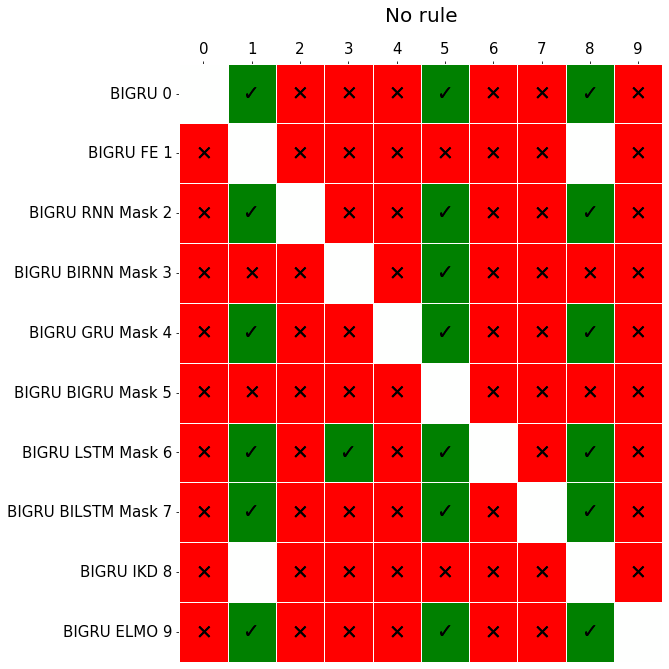

In [34]:
base = "bigru"
p_values = P_values_accuracy_one_rule_no_contrast[base]

bases = [base]
for base in bases:

    models = [base+"_model", base+"_model_FE"]
    model_types = ["base_model", "base_model_FE"]
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        models.append(base+"_"+mask+"_mask_model")
        model_types.append("mask_model")
#     for mask in masks:
#         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#         for contrast in contrasts:
#             if contrast==mask:
#                 models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                 model_types.append("mask_contrast_model")
    models.append(base+"_model-IKD-PAD_MASK_ZERO")
    model_types.append("IKD")
    models.append(base+"_model-ELMO")
    model_types.append("CWE")

rows = []
for index, model in enumerate(models):
    if model_types[index] == "base_model":
        base_model = model.split("_")[0].upper()+" "+str(index)
        rows.append(base_model)
    elif model_types[index] == "base_model_FE":
        fe_model = model.split("_")[0].upper()+" FE"+" "+str(index)
        rows.append(fe_model)
    elif model_types[index] == "base_model_FE-CONTRAST-ONLY":
        fec_model = model.split("_")[0].upper()+" FE"+" "+str(index)
        rows.append(fec_model)
    elif model_types[index] == "mask_model":
        mask_model = model.split("_")[0].upper()+" "+model.split("_")[1].upper()+" Mask"+" "+str(index)
        rows.append(mask_model)
#     elif model_types[index] == "mask_contrast_model":
#         mask_contrast_model = model.split("_")[0].upper()+" "+model.split("_")[3].upper()+" Contrast, "+model.split("_")[1].upper()+" Mask"+" "+str(index)
#         rows.append(mask_contrast_model)
    elif model_types[index] == "IKD":
        ikd_model = model.split("_")[0].upper()+" IKD"+" "+str(index)
        rows.append(ikd_model)
    elif model_types[index] == "CWE":
        ikd_model = model.split("_")[0].upper()+" ELMO"+" "+str(index)
        rows.append(ikd_model)

fig, ax_overall = plt.subplots(figsize=(10, 10))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "white", "green"])
labels = rows

ax_overall = sns.heatmap(p_values, annot=False, linewidths=.5, linecolor='white', cmap=cmap, cbar=False, ax=ax_overall)
ax_overall.set_title('No rule', pad=20)
plt.setp(ax_overall.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
# ax_overall.set_xticklabels(labels)
ax_overall.set_yticklabels(labels)
ax_overall.xaxis.tick_top()

params = {'font.size': 30,
          'axes.labelsize': 30,
          'axes.titlesize': 20,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'axes.titlepad': 12,
         'axes.axisbelow': True}
plt.rcParams.update(params)

for i in range(len(labels)):
    for j in range(len(labels)):
        if p_values[i][j] == 0.5:
            continue
        elif p_values[i][j] == 1:
            text = ax_overall.text(j+0.5, i+0.5, '✓', ha="center", va="center", color="black", fontsize=20)
        else:            
            text = ax_overall.text(j+0.5, i+0.5, '✕', ha="center", va="center", color="black", fontsize=20)
for i in range(len(labels)):
    for j in range(len(labels)):
        if p_values[i][j] == 0.5:
            continue        
        if p_values[i][j] == 1:
            text = ax_overall.text(j+0.5, i+0.5, '✓', ha="center", va="center", color="black", fontsize=20)
        else:            
            text = ax_overall.text(j+0.5, i+0.5, '✕', ha="center", va="center", color="black", fontsize=20)

fig.tight_layout()
# plt.savefig('analysis/NAACL_results/sentiment_acc_pvalues_overall.eps', bbox_inches = 'tight', facecolor='white', edgecolor='none')
plt.show()

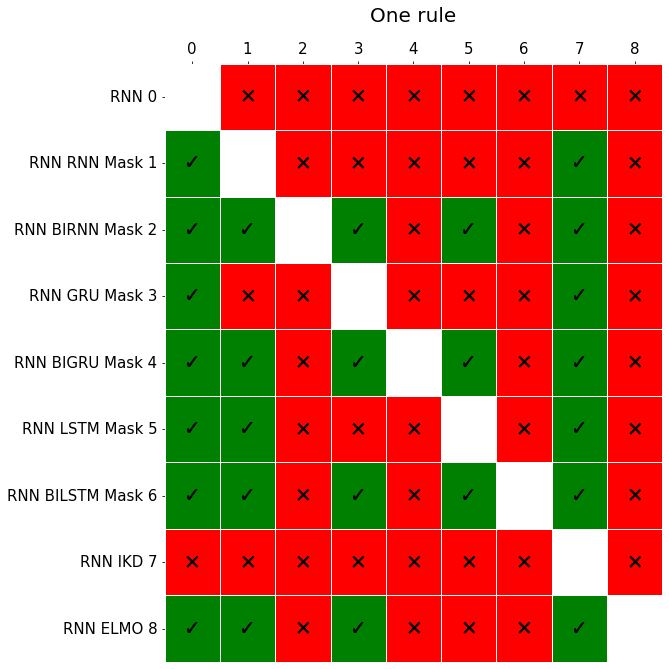

In [33]:
base = "rnn"
p_values = P_values_lime_one_rule_contrast[base]

bases = [base]
for base in bases:

    models = [base+"_model"]
    model_types = ["base_model"]
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        models.append(base+"_"+mask+"_mask_model")
        model_types.append("mask_model")
#     for mask in masks:
#         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#         for contrast in contrasts:
#             if contrast==mask:
#                 models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                 model_types.append("mask_contrast_model")
    models.append(base+"_model-IKD-EARLY_STOPP_VAL_ACC")
    model_types.append("IKD")
    models.append(base+"_model-ELMO")
    model_types.append("CWE")
    
rows = []
for index, model in enumerate(models):
    if model_types[index] == "base_model":
        base_model = model.split("_")[0].upper()+" "+str(index)
        rows.append(base_model)
    elif model_types[index] == "IKD":
        ikd_model = model.split("_")[0].upper()+" IKD"+" "+str(index)
        rows.append(ikd_model)
    elif model_types[index] == "mask_model":
        mask_model = model.split("_")[0].upper()+" "+model.split("_")[1].upper()+" Mask"+" "+str(index)
        rows.append(mask_model)
#     elif model_types[index] == "mask_contrast_model":
#         mask_contrast_model = model.split("_")[0].upper()+" "+model.split("_")[3].upper()+" Contrast, "+model.split("_")[1].upper()+" Mask"+" "+str(index)
#         rows.append(mask_contrast_model)
    elif model_types[index] == "IKD":
        ikd_model = model.split("_")[0].upper()+" IKD"+" "+str(index)
        rows.append(ikd_model)
    elif model_types[index] == "CWE":
        ikd_model = model.split("_")[0].upper()+" ELMO"+" "+str(index)
        rows.append(ikd_model)

fig, ax_overall = plt.subplots(figsize=(10, 10))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "white", "green"])
labels = rows

ax_overall = sns.heatmap(p_values, annot=False, linewidths=.5, linecolor='white', cmap=cmap, cbar=False, ax=ax_overall)
ax_overall.set_title('One rule', pad=20)
plt.setp(ax_overall.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
# ax_overall.set_xticklabels(labels)
ax_overall.set_yticklabels(labels)
ax_overall.xaxis.tick_top()

params = {'font.size': 30,
          'axes.labelsize': 30,
          'axes.titlesize': 20,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'axes.titlepad': 12,
         'axes.axisbelow': True}
plt.rcParams.update(params)

for i in range(len(labels)):
    for j in range(len(labels)):
        if p_values[i][j] == 0.5:
            continue
        elif p_values[i][j] == 1:
            text = ax_overall.text(j+0.5, i+0.5, '✓', ha="center", va="center", color="black", fontsize=20)
        else:            
            text = ax_overall.text(j+0.5, i+0.5, '✕', ha="center", va="center", color="black", fontsize=20)
for i in range(len(labels)):
    for j in range(len(labels)):
        if p_values[i][j] == 0.5:
            continue        
        if p_values[i][j] == 1:
            text = ax_overall.text(j+0.5, i+0.5, '✓', ha="center", va="center", color="black", fontsize=20)
        else:            
            text = ax_overall.text(j+0.5, i+0.5, '✕', ha="center", va="center", color="black", fontsize=20)

fig.tight_layout()
# plt.savefig('analysis/NAACL_results/sentiment_acc_pvalues_overall.eps', bbox_inches = 'tight', facecolor='white', edgecolor='none')
plt.show()

### Bar plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


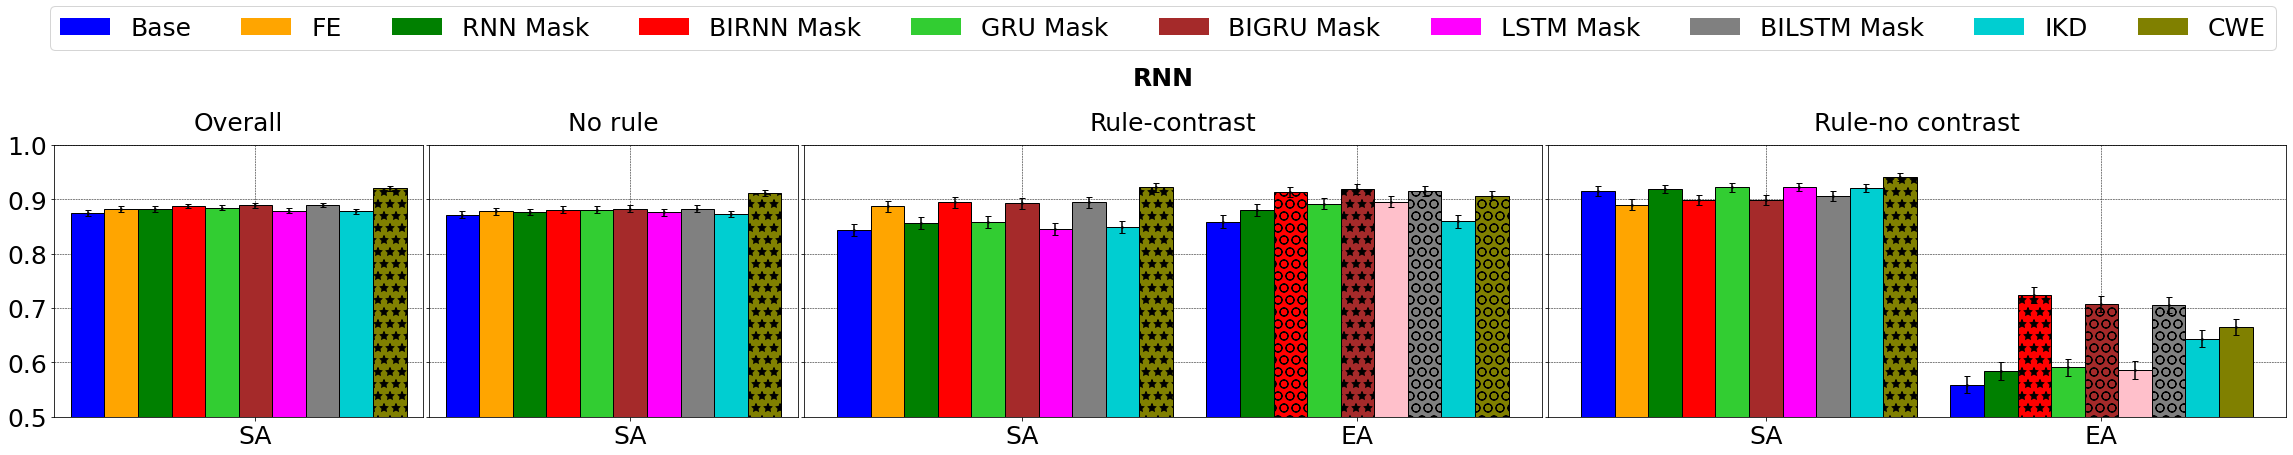

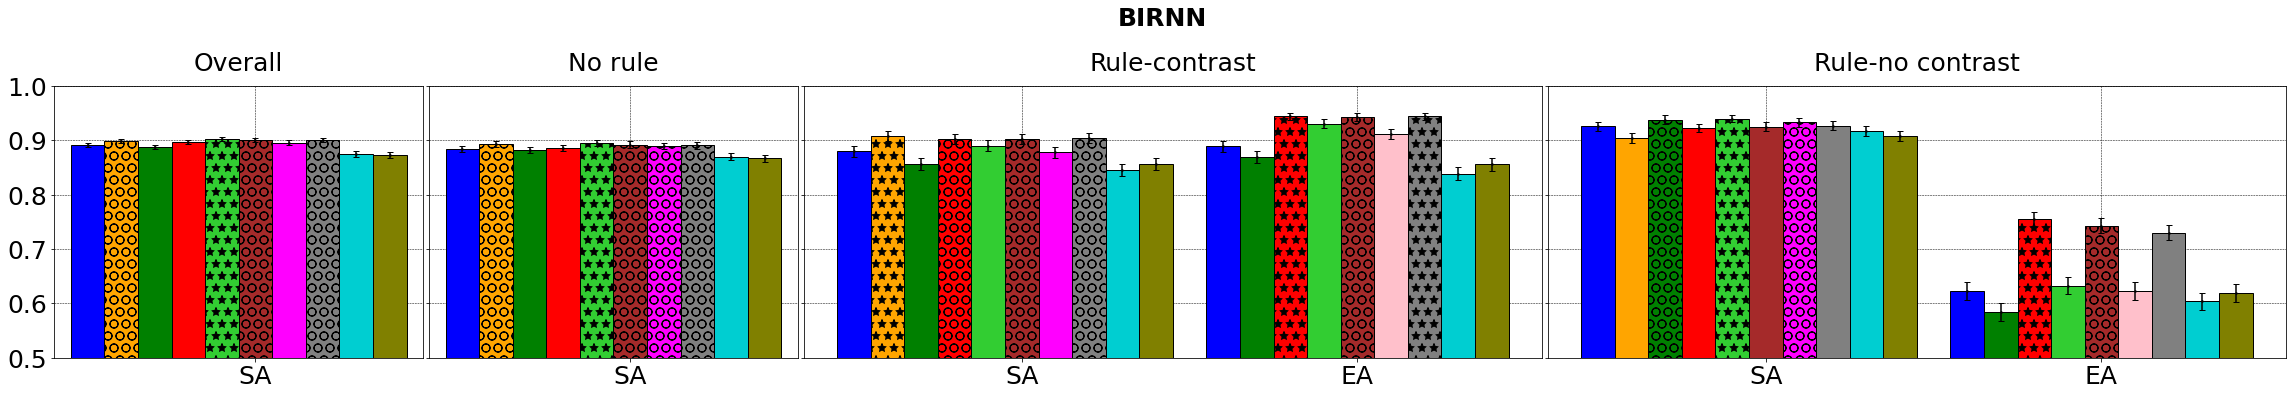

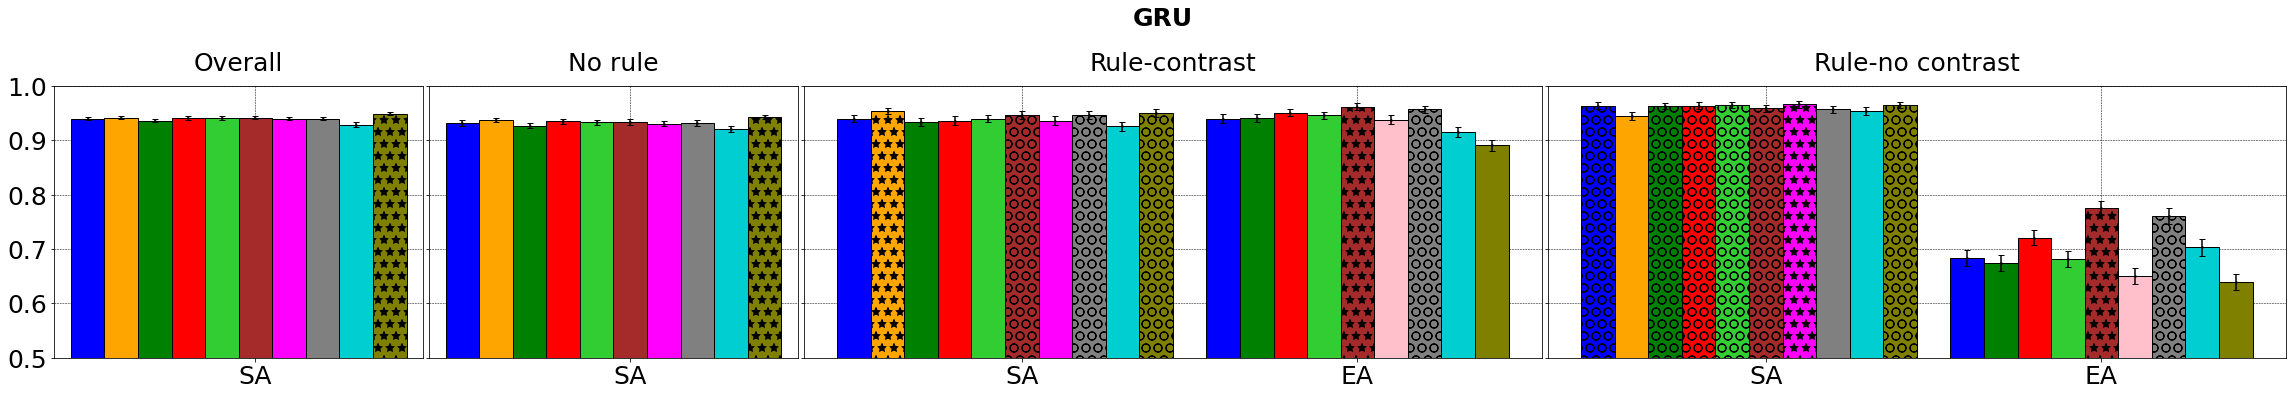

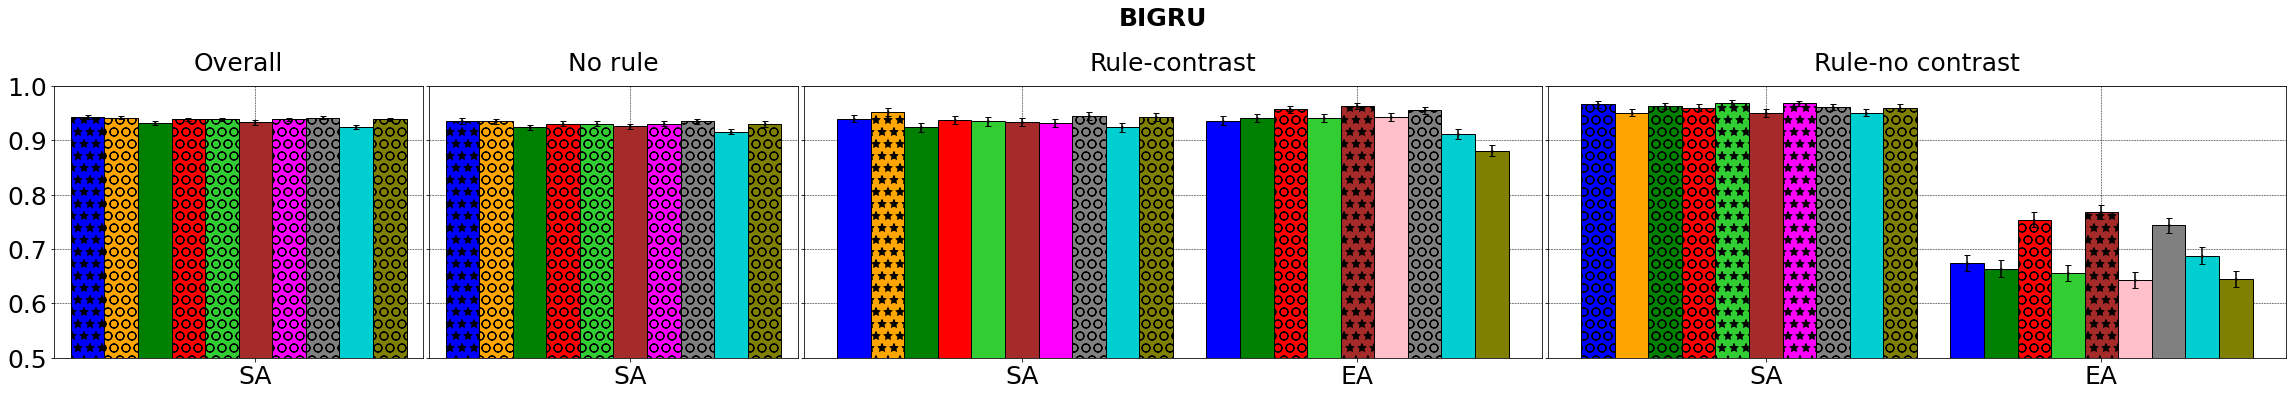

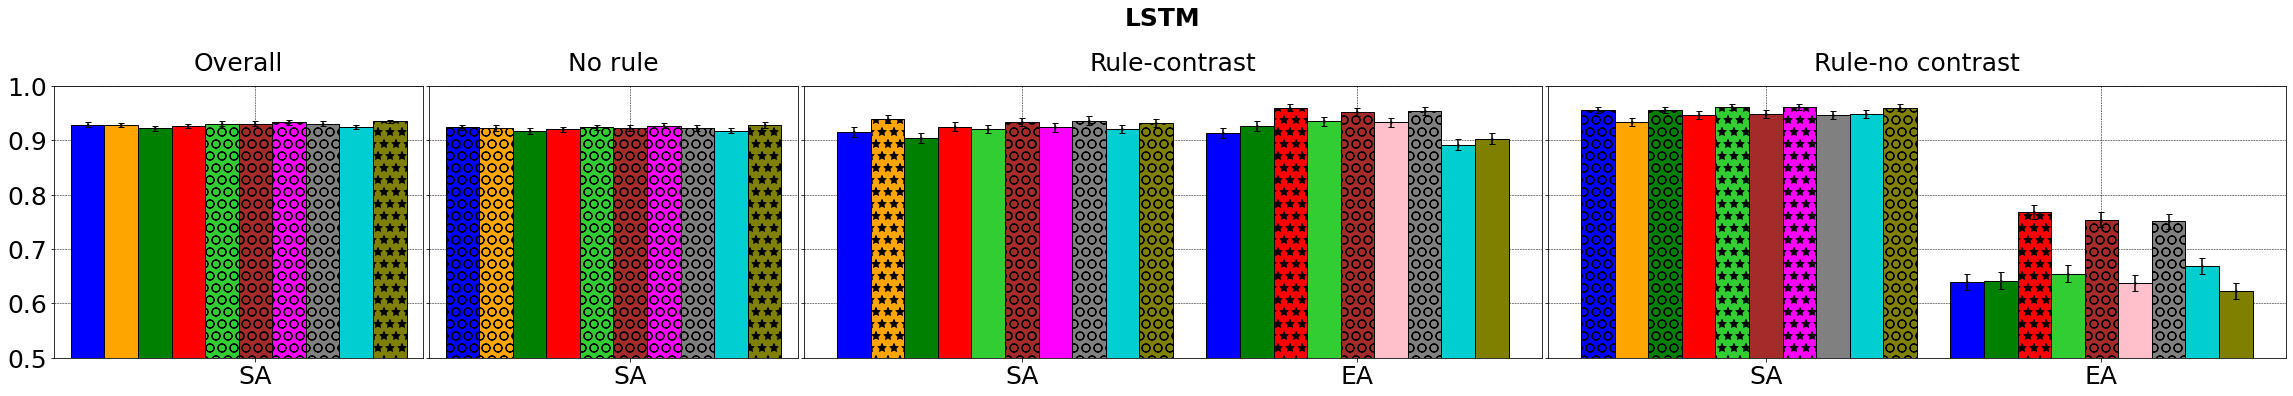

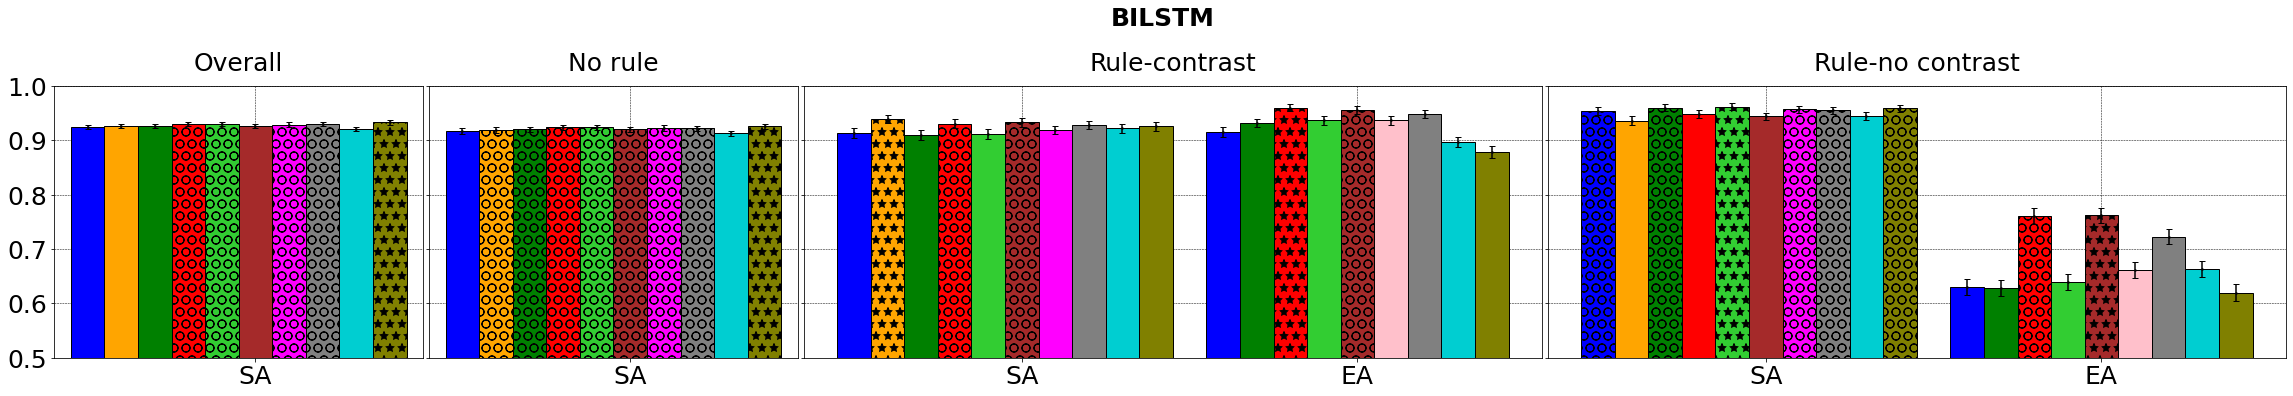

In [6]:
import os

# Graph parameters
params = {'figure.titlesize':25,
          'legend.fontsize': 25,
          'font.size': 15,
          'axes.labelsize': 25,
          'axes.titlesize':25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'axes.titlepad': 15,
          'axes.axisbelow': True}
plt.rcParams.update(params)

bases = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for base in bases:
    
    # generate the graphs
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(23, 5))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 5), gridspec_kw={'width_ratios': [1, 1, 2, 2], "wspace":0.01})
#     import matplotlib.gridspec as gridspec
#     gs1 = gridspec.GridSpec(1, 4, wspace=0, hspace=0, gridspec_kw={'width_ratios': [1, 1, 2, 2]})
#     ax1 = plt.subplot(gs1[0])
#     ax2 = plt.subplot(gs1[1])
#     ax3 = plt.subplot(gs1[2])
#     ax4 = plt.subplot(gs1[3])
    plt.axis('on')
    ax1.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax2.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax3.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax4.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax4.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
#     ax1.set_aspect('equal')
    ax2.set_yticklabels([])
#     ax2.set_aspect('equal')
    ax3.set_yticklabels([])
#     ax3.set_aspect('equal')
    ax4.set_yticklabels([])
#     ax4.set_aspect('equal')
    
    for test_dataset_part in ["overall", "no_rule", "one_rule_contrast", "one_rule_no_contrast"]:
        
        # get all models (columns)
        models = [base+"_model", base+"_model_FE"]
        lime_models = [base+"_model"]
        model_types = ["base_model", "base_model_FE"]
        lime_model_types = ["base_model"]
        masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
        for mask in masks:
            models.append(base+"_"+mask+"_mask_model")
            model_types.append("mask_model")
            lime_models.append(base+"_"+mask+"_mask_model")
            lime_model_types.append("mask_model")
#         for mask in masks:
#             contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#             for contrast in contrasts:
#                 if contrast==mask:
#                     models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                     model_types.append("mask_contrast_model")
        models.append(base+"_model-IKD-PAD_MASK_ZERO")
        model_types.append("IKD")
        lime_models.append(base+"_model-IKD-PAD_MASK_ZERO")
        lime_model_types.append("IKD")
        models.append(base+"_model-ELMO")
        model_types.append("CWE")
        lime_models.append(base+"_model-ELMO")
        lime_model_types.append("CWE")
        
        # generate the bar plots on the graph for all models
        sent_acc_mean_values = []
        sent_acc_std_values = []
        lime_acc_mean_values = []
        lime_acc_std_values = []
        colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]
        lime_colors = ["blue", "green", "red", "limegreen", "brown", "pink", "grey", "darkturquoise", "olive"]
        
        # generate x_coordinates per graph
        bar_width_overall_no_rule = 0.02
        bar_width_one_rule = 0.02
        if test_dataset_part == "overall" or test_dataset_part == "no_rule":
            x_coordinates = [index*bar_width_overall_no_rule for index, value in enumerate(models)]
        elif test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
            x_coordinates = [index*bar_width_one_rule for index, value in enumerate(models)]
            x_coordinates_lime = [x_coordinates[len(x_coordinates)-1]+bar_width_one_rule+(index+1)*bar_width_one_rule for index, value in enumerate(lime_models)]
        
        for index, model in enumerate(models):

            model_type = model_types[index]
#             color = colors[index]
#             x_coordinate = x_coordinates[index]
#             x_coordinate_lime = x_coordinates_lime[index]
        
            if model == "birnn_model":
                model = "birnn_model_256_hidden_units"
            if model == "birnn_model_FE":
                model = "birnn_model_FE-256_HIDDEN_UNITS"
            if model == "birnn_model_FE-CONTRAST-ONLY":
                model = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
            if model == "birnn_rnn_mask_model":
                model = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_birnn_mask_model":
                model = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_gru_mask_model":
                model = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bigru_mask_model":
                model = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_lstm_mask_model":
                model = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bilstm_mask_model":
                model = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_rnn_mask_rnn_contrast_model":
                model = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_birnn_mask_birnn_contrast_model":
                model = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_gru_mask_gru_contrast_model":
                model = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bigru_mask_bigru_contrast_model":
                model = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_lstm_mask_lstm_contrast_model":
                model = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"

            if model == "gru_gru_mask_model":
                model = "gru_gru_mask_model-3"
            if model == "lstm_bigru_mask_model":
                model = "lstm_bigru_mask_model-2"
            if model == "bigru_gru_mask_model":
                model = "bigru_gru_mask_model-2"
            if model == "lstm_gru_mask_model":
                model = "lstm_gru_mask_model-2"
            if model == "bilstm_gru_mask_model":
                model = "bilstm_gru_mask_model-2"
            if model == "lstm_bigru_mask_bigru_contrast_model":
                model = "lstm_bigru_mask_bigru_contrast_model-2"
            if model == "bilstm_bigru_mask_bigru_contrast_model":
                model = "bilstm_bigru_mask_bigru_contrast_model-2"
            if model == "gru_bigru_mask_bigru_contrast_model":
                model = "gru_bigru_mask_bigru_contrast_model-2"
            if model == "bigru_bigru_mask_bigru_contrast_model":
                model = "bigru_bigru_mask_bigru_contrast_model-2"
            if model == "lstm_bigru_mask_bigru_contrast_model":
                model = "lstm_bigru_mask_bigru_contrast_model-2"
            
            if model == "lstm_model-ELMO":
                model = "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "rnn_model-ELMO":
                model = "rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_model-ELMO":
                model = "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "bigru_model-ELMO":
                model = "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "bilstm_model-ELMO":
                model = "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"

            # Calculate corrects distribution
            with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                results_base = pickle.load(handle)
                results_base = pd.DataFrame(results_base)
            
            one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
            one_rule = one_rule.reset_index(drop=True)
            one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
            one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
            one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
            one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
            one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
            one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
            results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
            results_base = results_base.reset_index(drop=True)
            sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
            data_means_std = Sentiment_accuracy().calculate_mean_std(sentiment_corrects, sentiment_corrects, sentiment_corrects)
            
            if model_type == "base_model_FE":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "base_model_FE-CONTRAST-ONLY":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "IKD":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "CWE":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            else:
                sent_acc_means = data_means_std[model_type][test_dataset_part][0]
                sent_acc_std = data_means_std[model_type][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            
            if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
                if model_type!="base_model_FE":
                    with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                        results_base_lime_explanations = pickle.load(handle)
                        results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                    
                    results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                    
                    base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                    
                    if model_type == "IKD":
                        lime_acc_means = data_means_std["base_model"][test_dataset_part][0]
                        lime_acc_std = data_means_std["base_model"][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
                    elif model_type == "CWE":
                        lime_acc_means = data_means_std["base_model"][test_dataset_part][0]
                        lime_acc_std = data_means_std["base_model"][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
                    else:
                        lime_acc_means = data_means_std[model_type][test_dataset_part][0]
                        lime_acc_std = data_means_std[model_type][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
#                 elif model_type=="base_model_FE":
#                     lime_acc_mean_values.append(0.0)
#                     lime_acc_std_values.append(0.0)
            
        # Identify best performing model
        column_values_best_sent_acc_indices = [index for index, value in enumerate(sent_acc_mean_values) if value == max(sent_acc_mean_values)]
        if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
            column_values_best_lime_acc_indices = [index for index, value in enumerate(lime_acc_mean_values) if value == max(lime_acc_mean_values)]

        # Identify S.S. performing models
        if test_dataset_part=="overall":
            pvalues = P_values_accuracy_overall[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
        elif test_dataset_part == "no_rule":
            pvalues = P_values_accuracy_no_rule[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
        elif test_dataset_part == "one_rule_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_contrast[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            pvalues_lime_acc = P_values_lime_one_rule_contrast[base][column_values_best_lime_acc_indices[0]]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
        elif test_dataset_part == "one_rule_no_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_no_contrast[base][column_values_best_sent_acc_indices[0]]
            pvalues_lime_acc = P_values_lime_one_rule_no_contrast[base][column_values_best_lime_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
        
        # Plot the sent acc bar plots
        for index, model in enumerate(models):
            sent_acc_means = sent_acc_mean_values[index]
            sent_acc_std = sent_acc_std_values[index]
            sent_hatch=None
            sent_color = colors[index]
            x_coordinate_sent = x_coordinates[index]
            
            # Assign hatch values
            if index in column_values_best_sent_acc_indices:
                sent_hatch = '*'
            elif index in column_values_ss_sent_acc_indices:
                sent_hatch = 'O'
            
            # Plot
            if test_dataset_part=="overall":
                ax1.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax1.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
#                 ax1.text(x_coordinate_sent-0.01, sent_acc_means, str(sent_acc_means))
            elif test_dataset_part=="no_rule":
                ax2.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax2.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
            elif test_dataset_part=="one_rule_contrast":
                ax3.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax3.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
            elif test_dataset_part=="one_rule_no_contrast":
                ax4.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax4.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        
        # Plot the lime acc bar plots
        for index, model in enumerate(lime_models):
            if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
                lime_acc_means = lime_acc_mean_values[index]
                lime_acc_std = lime_acc_std_values[index]
                lime_hatch=None
                lime_color = lime_colors[index]
                x_coordinate_lime = x_coordinates_lime[index]
                
                # Assign hatch values
                if index in column_values_best_lime_acc_indices:
                    lime_hatch = '*'
                elif index in column_values_ss_lime_acc_indices:
                    lime_hatch = 'O'
                
                # Plot
                if test_dataset_part=="one_rule_contrast":
                    ax3.bar(x_coordinate_lime, lime_acc_means, bar_width_one_rule, yerr=lime_acc_std, edgecolor = 'black', linewidth = 1, color=lime_color, hatch=lime_hatch)
                    ax3.errorbar(x_coordinate_lime, lime_acc_means, yerr=lime_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
                elif test_dataset_part=="one_rule_no_contrast":
                    ax4.bar(x_coordinate_lime, lime_acc_means, bar_width_one_rule, yerr=lime_acc_std, edgecolor = 'black', linewidth = 1, color=lime_color, hatch=lime_hatch)
                    ax4.errorbar(x_coordinate_lime, lime_acc_means, yerr=lime_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        
        
#         for i, v in enumerate(y):
#             plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
        
    legends = []
    for index, model in enumerate(models):
        if model_types[index] == "base_model":
            legends.append("Base")
        elif model_types[index] == "base_model_FE":
            legends.append("FE")
        elif model_types[index] == "mask_model":
            mask_model = model.split("_")[1].upper()+" Mask"
            legends.append(mask_model)
        elif model_types[index] == "IKD":
            legends.append("IKD")
        elif model_types[index] == "CWE":
            legends.append("CWE")
            
#         for i in range(len(legends)):
#             legends.insert(2*i+1, '')

    fig.suptitle(base.upper(), x=0.51, y=1.1, weight="bold")
    ax1.set_title("Overall")
    ax1.set_xticks([x_coordinates[int(len(x_coordinates)/2)]])
    ax1.set_xticklabels(['SA'], weight = "roman")
    ax1.set_ylim(0.5, 1)
    
    ax2.set_title("No rule")
    ax2.set_xticks([x_coordinates[int(len(x_coordinates)/2)]])
    ax2.set_xticklabels(['SA'], weight = "roman")
    ax2.set_ylim(0.5, 1)
    
    ax3.set_title("Rule-contrast")
    ax3.set_xticks([x_coordinates[int(len(x_coordinates)/2)], x_coordinates_lime[int(len(x_coordinates_lime)/2)]])
    ax3.set_xticklabels(['SA', 'EA'], weight = "roman")
    
    ax3.set_ylim(0.5, 1)
    
    ax4.set_title("Rule-no contrast")
    ax4.set_xticks([x_coordinates[int(len(x_coordinates)/2)], x_coordinates_lime[int(len(x_coordinates_lime)/2)]])
    ax4.set_xticklabels(['SA', 'EA'], weight = "roman")
    ax4.set_ylim(0.5, 1)

#         fig.legend(legends, loc='center left', bbox_to_anchor=(-0.19, 0.5))
    if base == "rnn":
        import matplotlib.patches as mpatches
        recs = []
        for i in range(len(colors)):
            recs.append(mpatches.Rectangle((0,0), 1, 1, fc=colors[i]))
        fig.legend(recs, legends, loc='upper center', ncol=len(legends), bbox_to_anchor=(0.51, 1.3))
#         for legobj in leg.legendHandles:
#     legobj.set_linewidth(10.0)

    # Show the graph
    fig.tight_layout()
    if not os.path.exists("analysis/NAACL_results/"):
         os.makedirs("analysis/NAACL_results/")
    fig.savefig("analysis/NAACL_results/"+base.upper()+"_bar_plots.eps", bbox_inches = 'tight', facecolor='white', edgecolor='none')
    fig.show()

In [ ]:
import os

# Graph parameters
params = {'figure.titlesize':25,
          'legend.fontsize': 25,
          'font.size': 15,
          'axes.labelsize': 25,
          'axes.titlesize':25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'axes.titlepad': 15,
          'axes.axisbelow': True}
plt.rcParams.update(params)

bases = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for base in bases:
    
    # generate the graphs
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(23, 5))
    
    fig, ax1 = plt.subplots(figsize=(40, 5))
    plt.axis('on')
    ax1.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    
    for test_dataset_part in ["overall", "no_rule", "one_rule_contrast", "one_rule_no_contrast"]:
        
        # get all models (columns)
        models = [base+"_model", base+"_model_FE"]
        lime_models = [base+"_model"]
        model_types = ["base_model", "base_model_FE"]
        lime_model_types = ["base_model"]
        masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
        for mask in masks:
            models.append(base+"_"+mask+"_mask_model")
            model_types.append("mask_model")
            lime_models.append(base+"_"+mask+"_mask_model")
            lime_model_types.append("mask_model")
#         for mask in masks:
#             contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#             for contrast in contrasts:
#                 if contrast==mask:
#                     models.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                     model_types.append("mask_contrast_model")
        models.append(base+"_model-IKD-PAD_MASK_ZERO")
        model_types.append("IKD")
        lime_models.append(base+"_model-IKD-PAD_MASK_ZERO")
        lime_model_types.append("IKD")
        models.append(base+"_model-ELMO")
        model_types.append("CWE")
        lime_models.append(base+"_model-ELMO")
        lime_model_types.append("CWE")
        
        # generate the bar plots on the graph for all models
        sent_acc_mean_values = []
        sent_acc_std_values = []
        lime_acc_mean_values = []
        lime_acc_std_values = []
        colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]
        lime_colors = ["blue", "green", "red", "limegreen", "brown", "pink", "grey", "darkturquoise", "olive"]
        
        # generate x_coordinates per graph
        bar_width_overall_no_rule = 0.02
        bar_width_one_rule = 0.02
        if test_dataset_part == "overall" or test_dataset_part == "no_rule":
            x_coordinates = [index*bar_width_overall_no_rule for index, value in enumerate(models)]
        elif test_dataset_part == "one_rule_contrast" or test_dataset_part == "one_rule_no_contrast":
            x_coordinates = [index*bar_width_one_rule for index, value in enumerate(models)]
            x_coordinates_lime = [x_coordinates[len(x_coordinates)-1]+bar_width_one_rule+(index+1)*bar_width_one_rule for index, value in enumerate(lime_models)]
        
        for index, model in enumerate(models):

            model_type = model_types[index]
#             color = colors[index]
#             x_coordinate = x_coordinates[index]
#             x_coordinate_lime = x_coordinates_lime[index]
        
            if model == "birnn_model":
                model = "birnn_model_256_hidden_units"
            if model == "birnn_model_FE":
                model = "birnn_model_FE-256_HIDDEN_UNITS"
            if model == "birnn_model_FE-CONTRAST-ONLY":
                model = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
            if model == "birnn_rnn_mask_model":
                model = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_birnn_mask_model":
                model = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_gru_mask_model":
                model = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bigru_mask_model":
                model = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_lstm_mask_model":
                model = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bilstm_mask_model":
                model = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_rnn_mask_rnn_contrast_model":
                model = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_birnn_mask_birnn_contrast_model":
                model = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_gru_mask_gru_contrast_model":
                model = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_bigru_mask_bigru_contrast_model":
                model = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_lstm_mask_lstm_contrast_model":
                model = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"

            if model == "gru_gru_mask_model":
                model = "gru_gru_mask_model-3"
            if model == "lstm_bigru_mask_model":
                model = "lstm_bigru_mask_model-2"
            if model == "bigru_gru_mask_model":
                model = "bigru_gru_mask_model-2"
            if model == "lstm_gru_mask_model":
                model = "lstm_gru_mask_model-2"
            if model == "bilstm_gru_mask_model":
                model = "bilstm_gru_mask_model-2"
            if model == "lstm_bigru_mask_bigru_contrast_model":
                model = "lstm_bigru_mask_bigru_contrast_model-2"
            if model == "bilstm_bigru_mask_bigru_contrast_model":
                model = "bilstm_bigru_mask_bigru_contrast_model-2"
            if model == "gru_bigru_mask_bigru_contrast_model":
                model = "gru_bigru_mask_bigru_contrast_model-2"
            if model == "bigru_bigru_mask_bigru_contrast_model":
                model = "bigru_bigru_mask_bigru_contrast_model-2"
            if model == "lstm_bigru_mask_bigru_contrast_model":
                model = "lstm_bigru_mask_bigru_contrast_model-2"
            
            if model == "lstm_model-ELMO":
                model = "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "rnn_model-ELMO":
                model = "rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "birnn_model-ELMO":
                model = "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "bigru_model-ELMO":
                model = "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
            if model == "bilstm_model-ELMO":
                model = "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"

            # Calculate corrects distribution
            with open(model_type+"/assets/results/"+model+".pickle", 'rb') as handle:
                results_base = pickle.load(handle)
                results_base = pd.DataFrame(results_base)
            
            one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
            one_rule = one_rule.reset_index(drop=True)
            one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
            one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
            one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
            one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
            one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
            one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
            results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
            results_base = results_base.reset_index(drop=True)
            sentiment_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
            data_means_std = Sentiment_accuracy().calculate_mean_std(sentiment_corrects, sentiment_corrects, sentiment_corrects)
            
            if model_type == "base_model_FE":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "base_model_FE-CONTRAST-ONLY":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "IKD":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            elif model_type == "CWE":
                sent_acc_means = data_means_std["base_model"][test_dataset_part][0]
                sent_acc_std = data_means_std["base_model"][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            else:
                sent_acc_means = data_means_std[model_type][test_dataset_part][0]
                sent_acc_std = data_means_std[model_type][test_dataset_part][1]
                sent_acc_mean_values.append(sent_acc_means)
                sent_acc_std_values.append(sent_acc_std)
            
            if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
                if model_type!="base_model_FE":
                    with open(model_type+"/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                        results_base_lime_explanations = pickle.load(handle)
                        results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
                    
                    results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
                    results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
                    results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
                    
                    base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    mask_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    mask_contrast_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)
                    data_means_std = Lime_explanation_accuracy().calculate_mean_std(base_lime_corrects, mask_lime_corrects, mask_contrast_lime_corrects)
                    
                    if model_type == "IKD":
                        lime_acc_means = data_means_std["base_model"][test_dataset_part][0]
                        lime_acc_std = data_means_std["base_model"][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
                    elif model_type == "CWE":
                        lime_acc_means = data_means_std["base_model"][test_dataset_part][0]
                        lime_acc_std = data_means_std["base_model"][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
                    else:
                        lime_acc_means = data_means_std[model_type][test_dataset_part][0]
                        lime_acc_std = data_means_std[model_type][test_dataset_part][1]
                        lime_acc_mean_values.append(lime_acc_means)
                        lime_acc_std_values.append(lime_acc_std)
#                 elif model_type=="base_model_FE":
#                     lime_acc_mean_values.append(0.0)
#                     lime_acc_std_values.append(0.0)
            
        # Identify best performing model
        column_values_best_sent_acc_indices = [index for index, value in enumerate(sent_acc_mean_values) if value == max(sent_acc_mean_values)]
        if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
            column_values_best_lime_acc_indices = [index for index, value in enumerate(lime_acc_mean_values) if value == max(lime_acc_mean_values)]

        # Identify S.S. performing models
        if test_dataset_part=="overall":
            pvalues = P_values_accuracy_overall[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
        elif test_dataset_part == "no_rule":
            pvalues = P_values_accuracy_no_rule[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues) if pvalue==0]
        elif test_dataset_part == "one_rule_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_contrast[base][column_values_best_sent_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            pvalues_lime_acc = P_values_lime_one_rule_contrast[base][column_values_best_lime_acc_indices[0]]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
        elif test_dataset_part == "one_rule_no_contrast":
            pvalues_sent_acc = P_values_accuracy_one_rule_no_contrast[base][column_values_best_sent_acc_indices[0]]
            pvalues_lime_acc = P_values_lime_one_rule_no_contrast[base][column_values_best_lime_acc_indices[0]]
            column_values_ss_sent_acc_indices = [index for index, pvalue in enumerate(pvalues_sent_acc) if pvalue==0]
            column_values_ss_lime_acc_indices = [index for index, pvalue in enumerate(pvalues_lime_acc) if pvalue==0]
        
        # Plot the sent acc bar plots
        for index, model in enumerate(models):
            sent_acc_means = sent_acc_mean_values[index]
            sent_acc_std = sent_acc_std_values[index]
            sent_hatch=None
            sent_color = colors[index]
            x_coordinate_sent = x_coordinates[index]
            
            # Assign hatch values
            if index in column_values_best_sent_acc_indices:
                sent_hatch = '*'
            elif index in column_values_ss_sent_acc_indices:
                sent_hatch = 'O'
            
            # Plot
            if test_dataset_part=="overall":
                ax1.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax1.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
#                 ax1.text(x_coordinate_sent-0.01, sent_acc_means, str(sent_acc_means))
            elif test_dataset_part=="no_rule":
                ax2.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax2.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
            elif test_dataset_part=="one_rule_contrast":
                ax3.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax3.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
            elif test_dataset_part=="one_rule_no_contrast":
                ax4.bar(x_coordinate_sent, sent_acc_means, bar_width_overall_no_rule, yerr=sent_acc_std, edgecolor = 'black', linewidth = 1, color=sent_color, hatch=sent_hatch)
                ax4.errorbar(x_coordinate_sent, sent_acc_means, yerr=sent_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        
        # Plot the lime acc bar plots
        for index, model in enumerate(lime_models):
            if test_dataset_part=="one_rule" or test_dataset_part=="one_rule_contrast" or test_dataset_part=="one_rule_no_contrast":
                lime_acc_means = lime_acc_mean_values[index]
                lime_acc_std = lime_acc_std_values[index]
                lime_hatch=None
                lime_color = lime_colors[index]
                x_coordinate_lime = x_coordinates_lime[index]
                
                # Assign hatch values
                if index in column_values_best_lime_acc_indices:
                    lime_hatch = '*'
                elif index in column_values_ss_lime_acc_indices:
                    lime_hatch = 'O'
                
                # Plot
                if test_dataset_part=="one_rule_contrast":
                    ax3.bar(x_coordinate_lime, lime_acc_means, bar_width_one_rule, yerr=lime_acc_std, edgecolor = 'black', linewidth = 1, color=lime_color, hatch=lime_hatch)
                    ax3.errorbar(x_coordinate_lime, lime_acc_means, yerr=lime_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
                elif test_dataset_part=="one_rule_no_contrast":
                    ax4.bar(x_coordinate_lime, lime_acc_means, bar_width_one_rule, yerr=lime_acc_std, edgecolor = 'black', linewidth = 1, color=lime_color, hatch=lime_hatch)
                    ax4.errorbar(x_coordinate_lime, lime_acc_means, yerr=lime_acc_std, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        
        
#         for i, v in enumerate(y):
#             plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
        
    legends = []
    for index, model in enumerate(models):
        if model_types[index] == "base_model":
            legends.append("Base")
        elif model_types[index] == "base_model_FE":
            legends.append("FE")
        elif model_types[index] == "mask_model":
            mask_model = model.split("_")[1].upper()+" Mask"
            legends.append(mask_model)
        elif model_types[index] == "IKD":
            legends.append("IKD")
        elif model_types[index] == "CWE":
            legends.append("CWE")
            
#         for i in range(len(legends)):
#             legends.insert(2*i+1, '')

    fig.suptitle(base.upper(), x=0.51, y=1.1, weight="bold")
    ax1.set_title("Overall")
    ax1.set_xticks([x_coordinates[int(len(x_coordinates)/2)]])
    ax1.set_xticklabels(['SA'], weight = "roman")
    ax1.set_ylim(0.5, 1)
    
    ax2.set_title("No rule")
    ax2.set_xticks([x_coordinates[int(len(x_coordinates)/2)]])
    ax2.set_xticklabels(['SA'], weight = "roman")
    ax2.set_ylim(0.5, 1)
    
    ax3.set_title("Rule-contrast")
    ax3.set_xticks([x_coordinates[int(len(x_coordinates)/2)], x_coordinates_lime[int(len(x_coordinates_lime)/2)]])
    ax3.set_xticklabels(['SA', 'EA'], weight = "roman")
    
    ax3.set_ylim(0.5, 1)
    
    ax4.set_title("Rule-no contrast")
    ax4.set_xticks([x_coordinates[int(len(x_coordinates)/2)], x_coordinates_lime[int(len(x_coordinates_lime)/2)]])
    ax4.set_xticklabels(['SA', 'EA'], weight = "roman")
    ax4.set_ylim(0.5, 1)

#         fig.legend(legends, loc='center left', bbox_to_anchor=(-0.19, 0.5))
    if base == "rnn":
        import matplotlib.patches as mpatches
        recs = []
        for i in range(len(colors)):
            recs.append(mpatches.Rectangle((0,0), 1, 1, fc=colors[i]))
        fig.legend(recs, legends, loc='upper center', ncol=len(legends), bbox_to_anchor=(0.51, 1.3))
#         for legobj in leg.legendHandles:
#     legobj.set_linewidth(10.0)

    # Show the graph
    fig.tight_layout()
    if not os.path.exists("analysis/NAACL_results/"):
         os.makedirs("analysis/NAACL_results/")
    fig.savefig("analysis/NAACL_results/"+base.upper()+"_bar_plots.eps", bbox_inches = 'tight', facecolor='white', edgecolor='none')
    fig.show()

### Graphs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


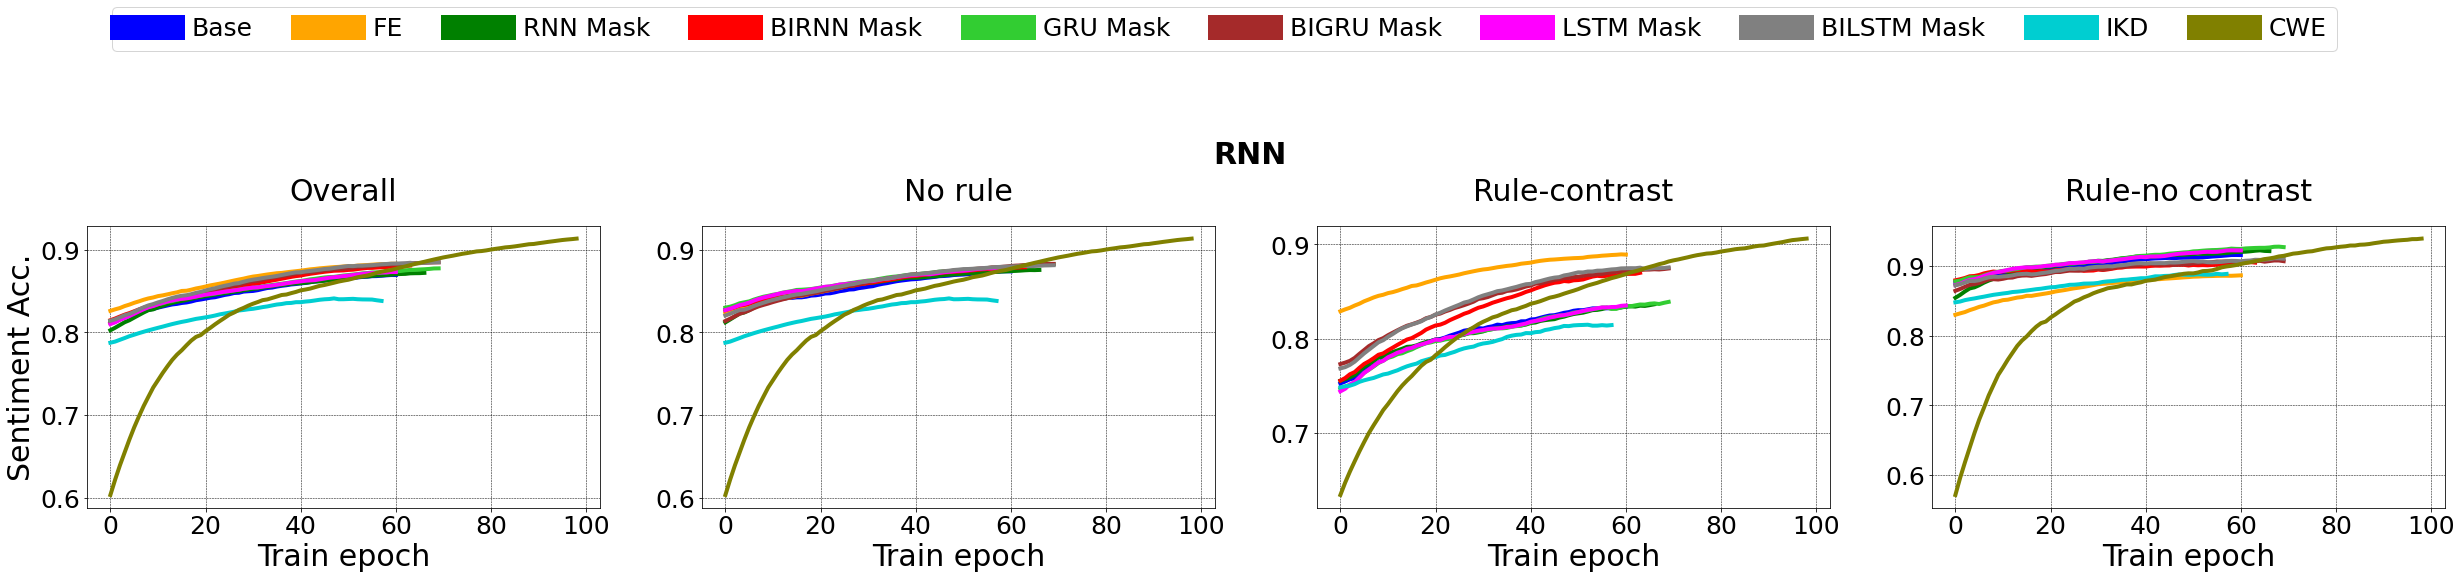

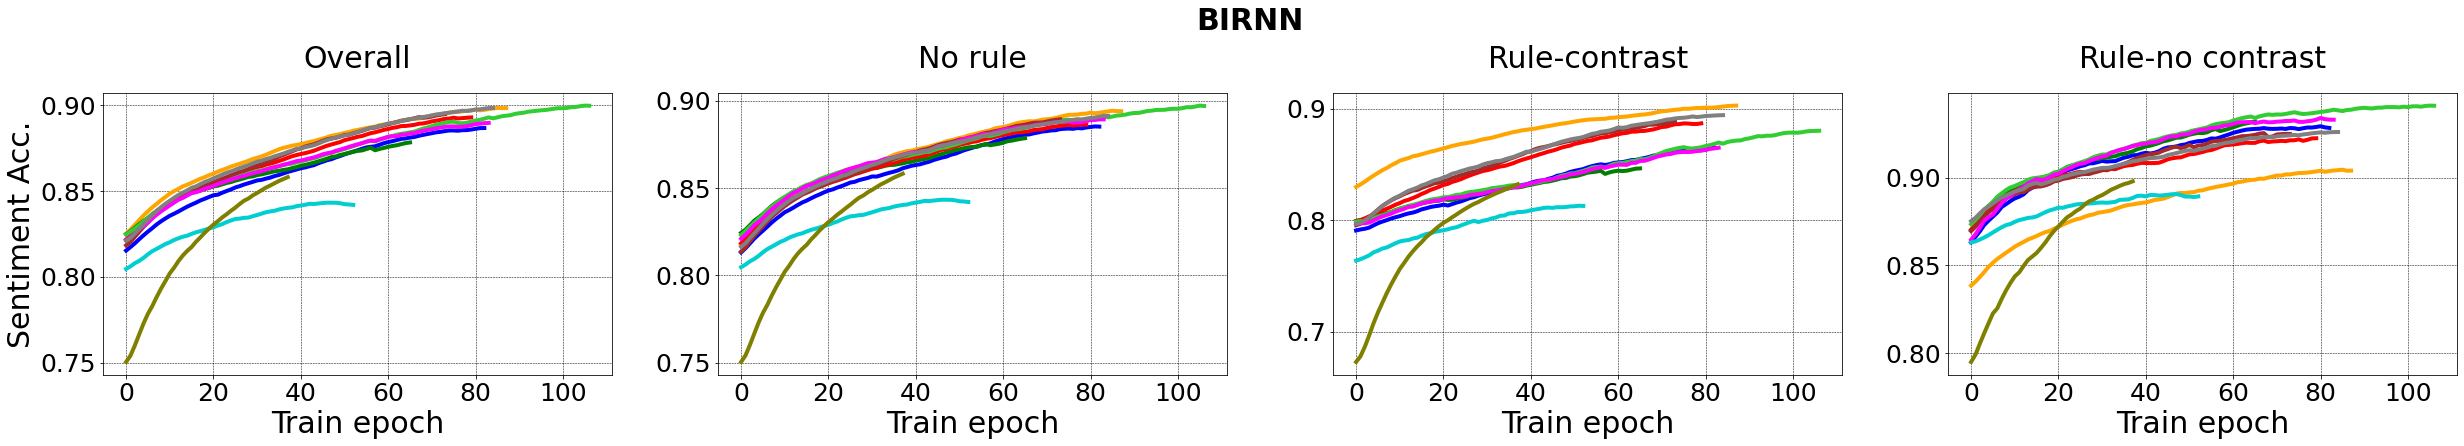

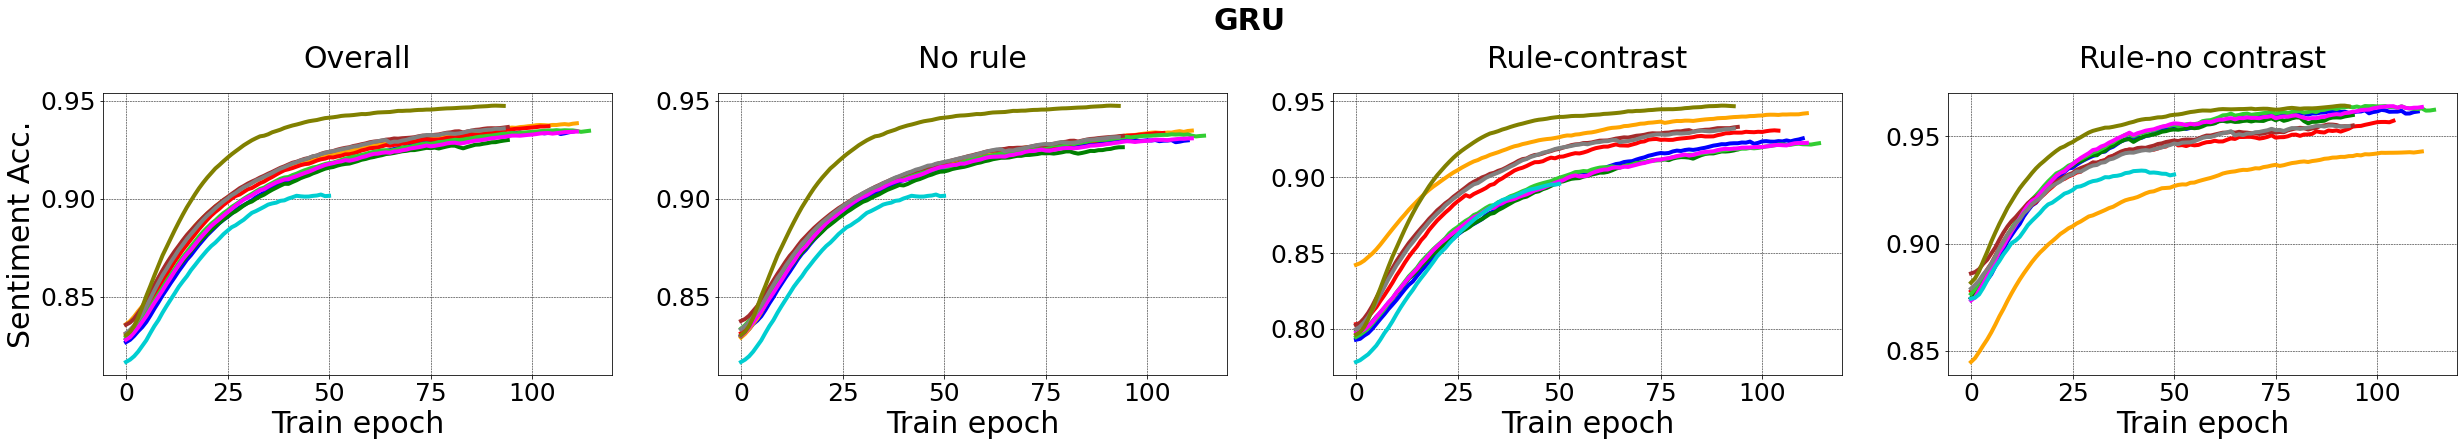

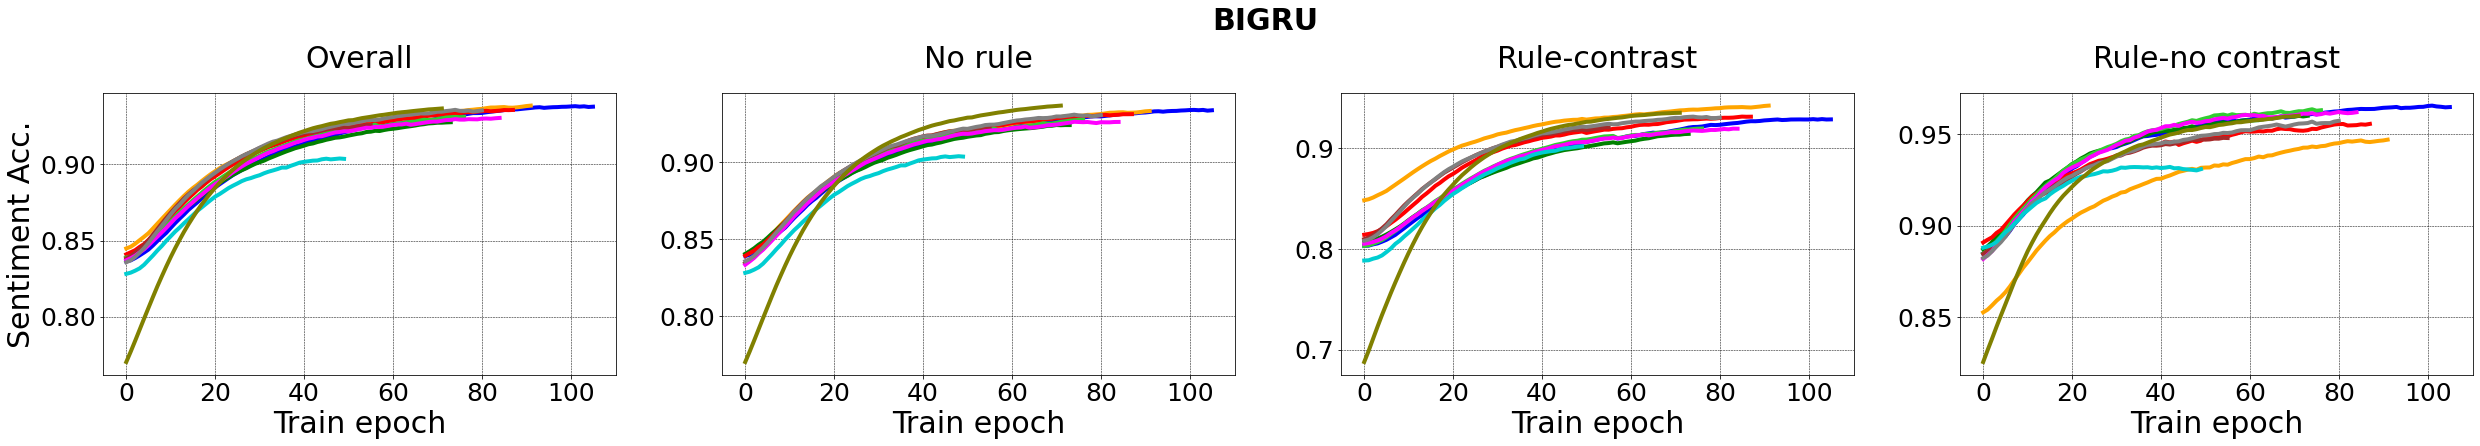

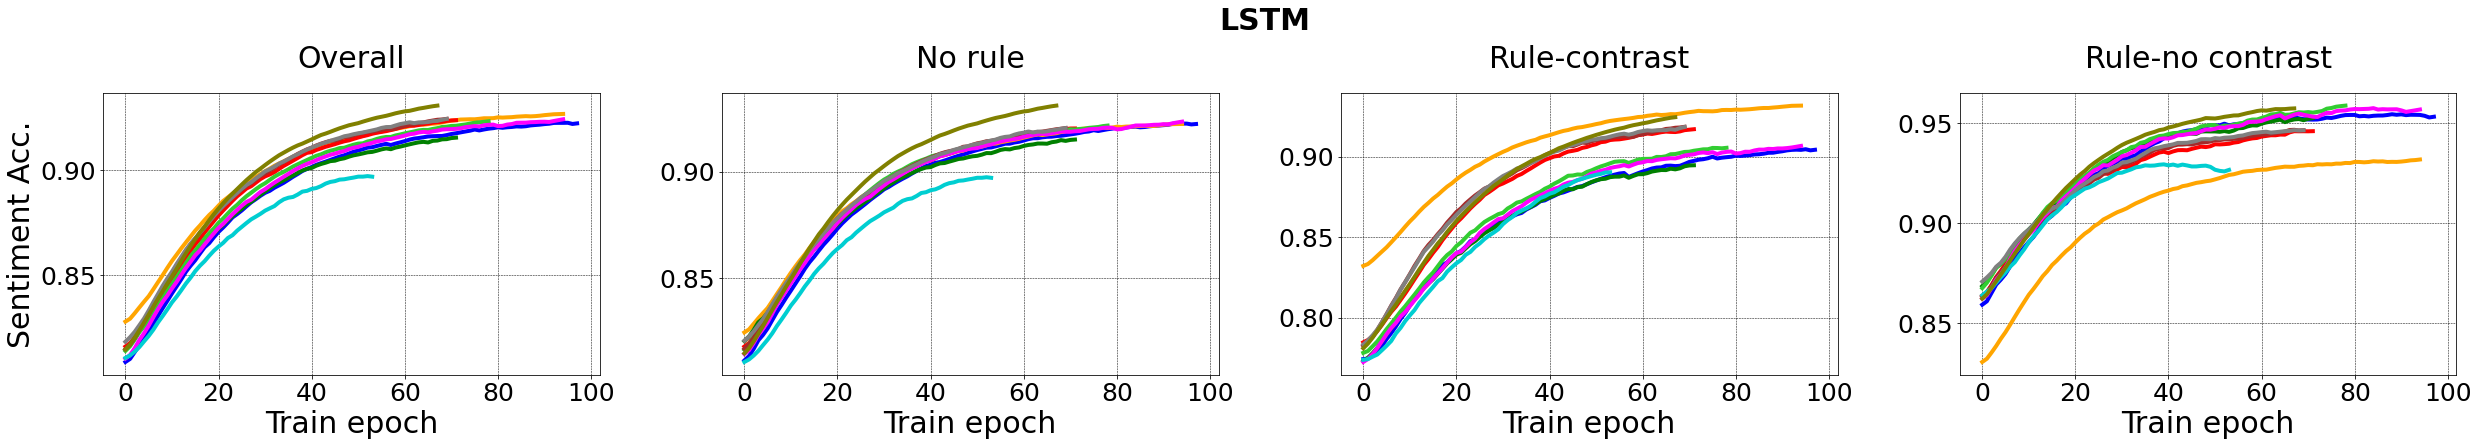

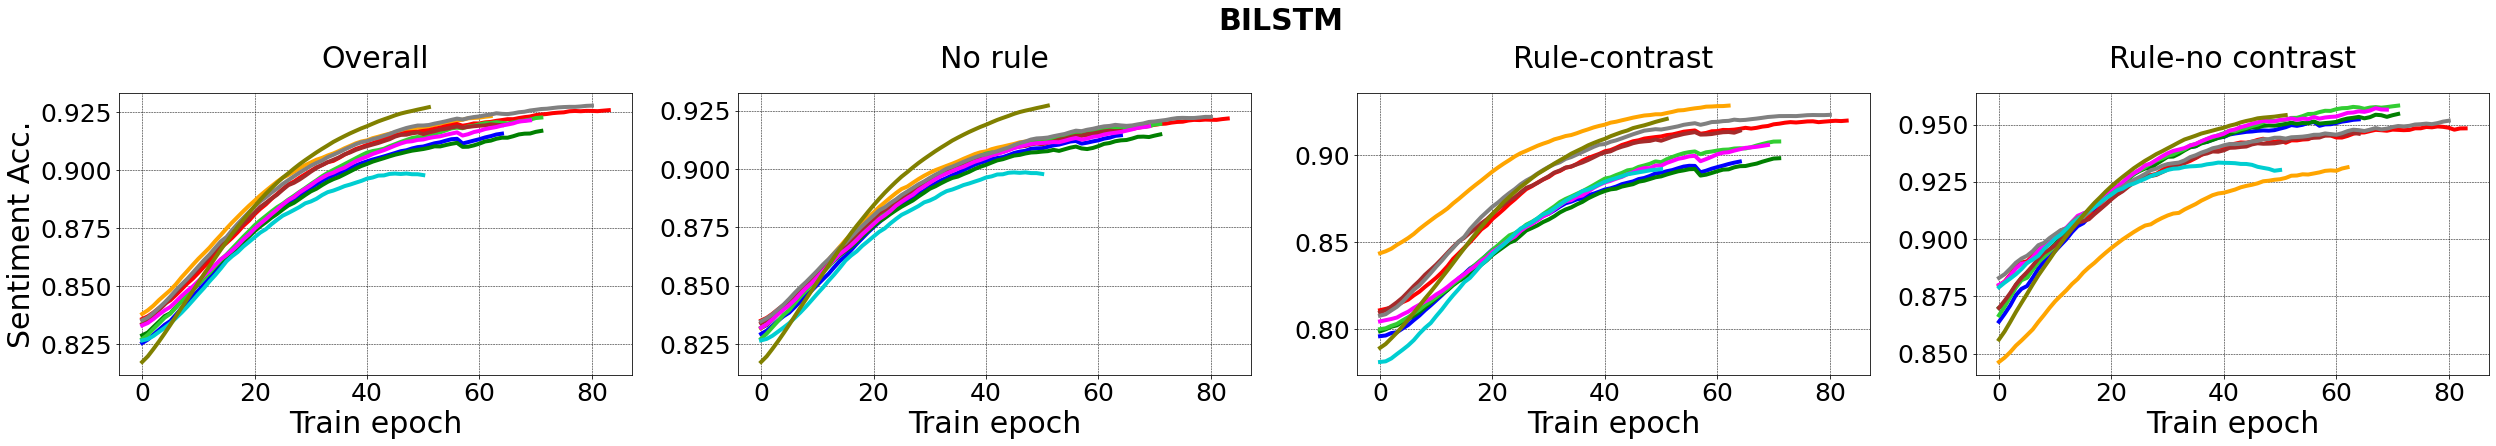

In [15]:
# Horizontal plots

def smooth(scalars, weight = 0.9):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

import os

# Graph parameters
params = {'figure.titlesize':30,
          'legend.fontsize': 25,
          'font.size': 25,
          'axes.labelsize': 30,
          'axes.titlesize':30,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'axes.titlepad': 25,
          'axes.axisbelow': True}
plt.rcParams.update(params)

bases = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for base in bases:

    # get legends
    legends = [base+"_model", base+"_model_FE"]
    model_types = ["base_model", "base_model_FE"]
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        legends.append(base+"_"+mask+"_mask_model")
        model_types.append("mask_model")
#     for mask in masks:
#         contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
#         for contrast in contrasts:
#             if contrast==mask:
#                 legends.append(base+"_"+mask+"_mask_"+contrast+"_contrast_model")
#                 model_types.append("mask_contrast_model")
    legends.append(base+"_model-IKD-PAD_MASK_ZERO")
    model_types.append("IKD")
    legends.append(base+"_model-ELMO")
    model_types.append("CWE")

    # generate the graph
    colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]
    fig_loss, (ax_loss_1, ax_loss_2, ax_loss_3, ax_loss_4) = plt.subplots(1, 4, figsize=(35, 7))
    ax_loss_1.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax_loss_2.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax_loss_3.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    ax_loss_4.grid(color = 'black', linestyle = '--', linewidth = 0.5)
    
    # generate the plots on the graph
    new_legends = []
    new_model_types = []
    for index, legend in enumerate(legends):
        color = colors[index]
        
        if legend == "birnn_model":
            legend = "birnn_model_256_hidden_units"
        if legend == "birnn_model_FE":
            legend = "birnn_model_FE-256_HIDDEN_UNITS"
        if legend == "birnn_model_FE-CONTRAST-ONLY":
            legend = "birnn_model_FE-CONTRAST-ONLY-256_HIDDEN_UNITS"
        if legend == "birnn_rnn_mask_model":
            legend = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_birnn_mask_model":
            legend = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_gru_mask_model":
            legend = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_bigru_mask_model":
            legend = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_lstm_mask_model":
            legend = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_bilstm_mask_model":
            legend = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_rnn_mask_rnn_contrast_model":
            legend = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_birnn_mask_birnn_contrast_model":
            legend = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_gru_mask_gru_contrast_model":
            legend = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_bigru_mask_bigru_contrast_model":
            legend = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_lstm_mask_lstm_contrast_model":
            legend = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        #             if legend == "birnn_bilstm_mask_bilstm_contrast_model":
        #                 legend = "birnn_bilstm_mask_bilstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"

        if legend == "gru_gru_mask_model":
            legend = "gru_gru_mask_model-3"
        if legend == "lstm_bigru_mask_model":
            legend = "lstm_bigru_mask_model-2"
        if legend == "bigru_gru_mask_model":
            legend = "bigru_gru_mask_model-2"
        if legend == "lstm_gru_mask_model":
            legend = "lstm_gru_mask_model-2"
        if legend == "bilstm_gru_mask_model":
            legend = "bilstm_gru_mask_model-2"
        if legend == "lstm_bigru_mask_bigru_contrast_model":
            legend = "lstm_bigru_mask_bigru_contrast_model-2"
        if legend == "bilstm_bigru_mask_bigru_contrast_model":
            legend = "bilstm_bigru_mask_bigru_contrast_model-2"
        if legend == "gru_bigru_mask_bigru_contrast_model":
            legend = "gru_bigru_mask_bigru_contrast_model-2"
        if legend == "bigru_bigru_mask_bigru_contrast_model":
            legend = "bigru_bigru_mask_bigru_contrast_model-2"
        if legend == "lstm_bigru_mask_bigru_contrast_model":
            legend = "lstm_bigru_mask_bigru_contrast_model-2"
            
        if legend == "lstm_model-ELMO":
            legend = "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if legend == "rnn_model-ELMO":
            legend = "rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if legend == "birnn_model-ELMO":
            legend = "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if legend == "bigru_model-ELMO":
            legend = "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        if legend == "bilstm_model-ELMO":
            legend = "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"
        
        try:
            with open(model_types[index]+"/assets/training_log/"+legend+".pickle", "rb") as handle:
                training_log = pickle.load(handle)
                new_legends.append(legend)
                new_model_types.append(model_types[index])

                # generate plots on the Overall graph
                if model_types[index] == "base_model" or model_types[index] == "base_model_FE" or model_types[index] == "base_model_FE-CONTRAST-ONLY":
                    training_log["test_dataset_accuracy_smoothed"] = smooth(training_log['test_dataset_accuracy'])
                    ax_loss_1.plot(training_log["test_dataset_accuracy_smoothed"], color=color, linewidth=4)
                elif model_types[index] == "mask_model" or model_types[index] == "mask_contrast_model":
                    training_log["test_dataset_output_accuracy_smoothed"] = smooth(training_log['test_dataset_output_accuracy'])
                    ax_loss_1.plot(training_log['test_dataset_output_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "CWE":
                    training_log["test_dataset_accuracy_smoothed"] = smooth(training_log['test_dataset_acc'])
                    ax_loss_1.plot(training_log["test_dataset_accuracy_smoothed"], color=color, linewidth=4)
                elif model_types[index] == "IKD":
                    training_log["test_dataset_accuracy_smoothed"] = smooth(training_log['val_accuracy'])
                    ax_loss_1.plot(training_log["test_dataset_accuracy_smoothed"], color=color, linewidth=4)

                # generate plots on the No rule graph
                if model_types[index] == "base_model" or model_types[index] == "base_model_FE" or model_types[index] == "base_model_FE-CONTRAST-ONLY":
                    training_log['test_dataset_no_rule_accuracy_smoothed'] = smooth(training_log['test_dataset_no_rule_accuracy'])
                    ax_loss_2.plot(training_log['test_dataset_no_rule_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "mask_model" or model_types[index] == "mask_contrast_model":
                    training_log['test_dataset_no_rule_output_accuracy_smoothed'] = smooth(training_log['test_dataset_no_rule_output_accuracy'])
                    ax_loss_2.plot(training_log['test_dataset_no_rule_output_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "CWE":
                    training_log["test_dataset_no_rule_accuracy_smoothed"] = smooth(training_log['test_dataset_no_rule_acc'])
                    ax_loss_2.plot(training_log["test_dataset_accuracy_smoothed"], color=color, linewidth=4)
                elif model_types[index] == "IKD":
                    training_log["test_dataset_no_rule_accuracy_smoothed"] = smooth(training_log['test_dataset_no_rule_accuracy'])
                    ax_loss_2.plot(training_log["test_dataset_accuracy_smoothed"], color=color, linewidth=4)

                # generate plots on the One rule, contrast graph
                if model_types[index] == "base_model" or model_types[index] == "base_model_FE" or model_types[index] == "base_model_FE-CONTRAST-ONLY":
                    training_log['test_dataset_one_rule_contrast_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_contrast_accuracy'])
                    ax_loss_3.plot(training_log['test_dataset_one_rule_contrast_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "mask_model" or model_types[index] == "mask_contrast_model":
                    training_log['test_dataset_one_rule_contrast_output_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_contrast_output_accuracy'])
                    ax_loss_3.plot(training_log['test_dataset_one_rule_contrast_output_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "CWE":
                    training_log['test_dataset_one_rule_contrast_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_contrast_acc'])
                    ax_loss_3.plot(training_log["test_dataset_one_rule_contrast_accuracy_smoothed"], color=color, linewidth=4)
                elif model_types[index] == "IKD":
                    training_log["test_dataset_one_rule_contrast_accuracy_smoothed"] = smooth(training_log['test_dataset_one_rule_contrast_accuracy'])
                    ax_loss_3.plot(training_log["test_dataset_one_rule_contrast_accuracy_smoothed"], color=color, linewidth=4)

                # generate plots on the One rule, no contrast graph
                if model_types[index] == "base_model" or model_types[index] == "base_model_FE" or model_types[index] == "base_model_FE-CONTRAST-ONLY":
                    training_log['test_dataset_one_rule_no_contrast_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_no_contrast_accuracy'])
                    ax_loss_4.plot(training_log['test_dataset_one_rule_no_contrast_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "mask_model" or model_types[index] == "mask_contrast_model":
                    training_log['test_dataset_one_rule_no_contrast_output_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_no_contrast_output_accuracy'])
                    ax_loss_4.plot(training_log['test_dataset_one_rule_no_contrast_output_accuracy_smoothed'], color=color, linewidth=4)
                elif model_types[index] == "CWE":
                    training_log['test_dataset_one_rule_no_contrast_accuracy_smoothed'] = smooth(training_log['test_dataset_one_rule_no_contrast_acc'])
                    ax_loss_4.plot(training_log["test_dataset_one_rule_no_contrast_accuracy_smoothed"], color=color, linewidth=4)
                elif model_types[index] == "IKD":
                    training_log["test_dataset_one_rule_no_contrast_accuracy_smoothed"] = smooth(training_log['test_dataset_one_rule_no_contrast_accuracy'])
                    ax_loss_4.plot(training_log["test_dataset_one_rule_no_contrast_accuracy_smoothed"], color=color, linewidth=4)
        except:
            continue
            
    # generate the legend, graph title (test dataset part), Supertitle (base)
    newer_legends = []
    for index, legend in enumerate(new_legends):
        if new_model_types[index] == "base_model":
            newer_legends.append("Base")
        elif new_model_types[index] == "base_model_FE":
            newer_legends.append("FE")
        elif new_model_types[index] == "base_model_FE-CONTRAST-ONLY":
            newer_legends.append("FE-C")
        elif new_model_types[index] == "mask_model":
            mask_model = legend.split("_")[1].upper()+" Mask"
            newer_legends.append(mask_model)
        elif new_model_types[index] == "mask_contrast_model":
            mask_contrast_model = legend.split("_")[3].upper()+" Contrast, "+legend.split("_")[1].upper()+" Mask"
            newer_legends.append(mask_contrast_model)
        elif new_model_types[index] == "IKD":
            newer_legends.append("IKD")
        elif new_model_types[index] == "CWE":
            newer_legends.append("CWE")
            
    fig_loss.suptitle(base.upper(), x=0.51, y=0.91, weight="bold")
    ax_loss_1.set_title("Overall")
    ax_loss_1.set_ylabel('Sentiment Acc.')
    ax_loss_1.set_xlabel('Train epoch')
    ax_loss_2.set_title("No rule")
#     ax_loss_2.set_ylabel('Sentiment Acc.')
    ax_loss_2.set_xlabel('Train epoch')
    ax_loss_3.set_title("Rule-contrast")
#     ax_loss_3.set_ylabel('Sentiment Acc.')
    ax_loss_3.set_xlabel('Train epoch')
    ax_loss_4.set_title("Rule-no contrast")
#     ax_loss_4.set_ylabel('Sentiment Acc.')
    ax_loss_4.set_xlabel('Train epoch')
    if base == "rnn":
#         import matplotlib.patches as mpatches
#         recs = []
#         for i in range(len(colors)):
#             recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
#         fig_loss.legend(recs, legends, loc='upper center', ncol=len(legends), bbox_to_anchor=(0.5, 1.2))
        leg = fig_loss.legend(newer_legends, loc='upper center', ncol=len(newer_legends), bbox_to_anchor=(0.5, 1.2))
        for legobj in leg.legendHandles:
            legobj.set_linewidth(25.0)
        
    # Show the graph
    fig_loss.tight_layout()
    if not os.path.exists("analysis/NAACL_results/"):
        os.makedirs("analysis/NAACL_results/")
    fig_loss.savefig("analysis/NAACL_results/"+base.upper()+"_sentiment_acc_vs_train_epochs.eps", bbox_inches = 'tight', facecolor='white', edgecolor='none')
    fig_loss.show()

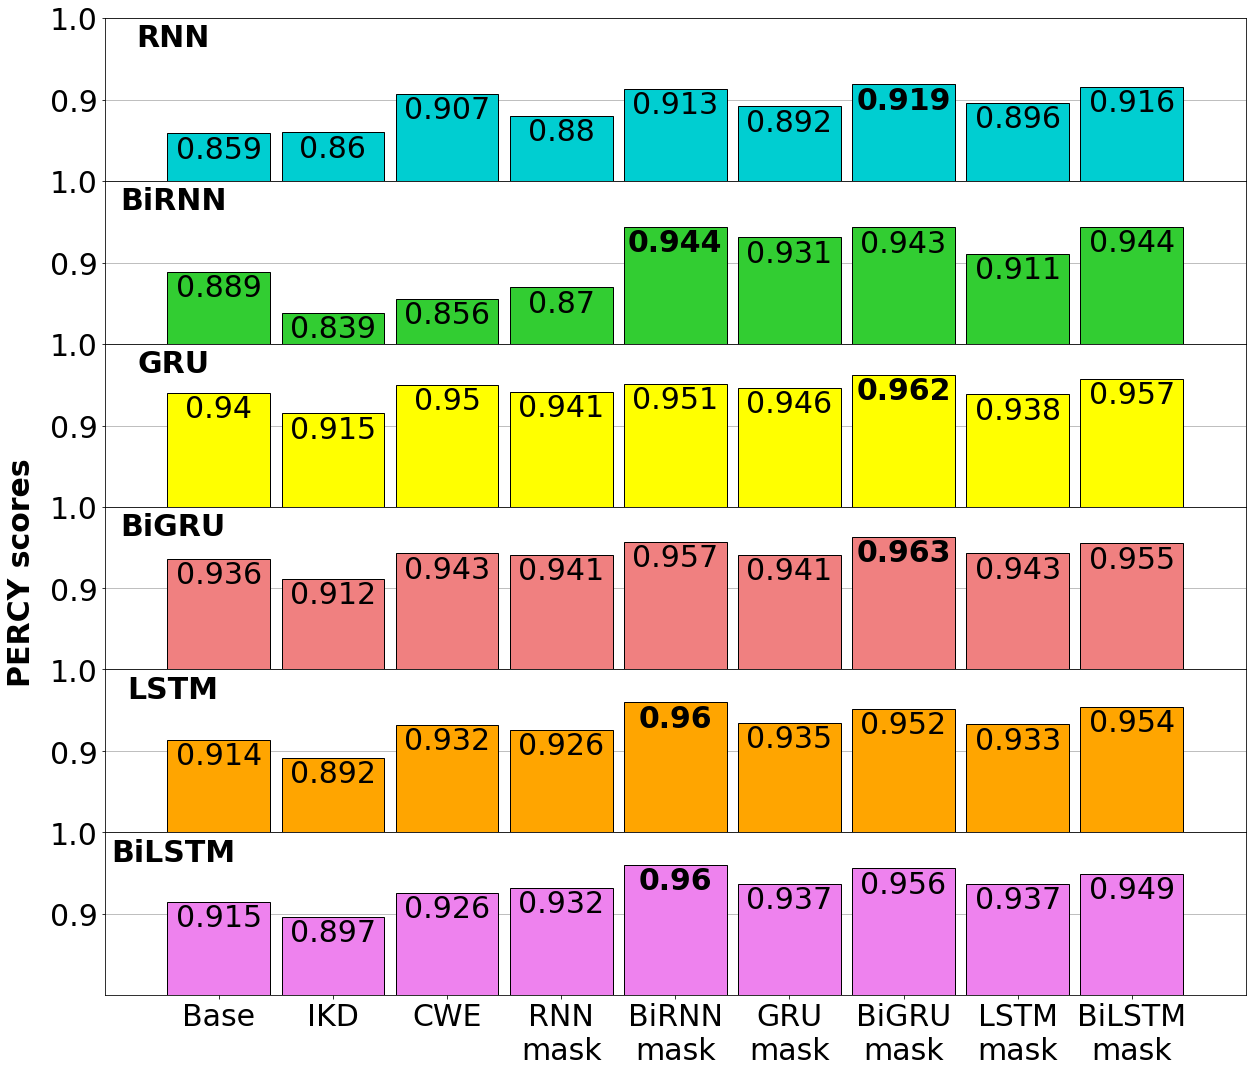

In [10]:
# Bar plots for ECIR draft
models = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
clrs = ["darkturquoise", "limegreen", "yellow", "lightcoral", "orange", "violet"]
#["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]

#Rule subset
# RNN = [0.704, 0.748, 0.785, 0.727, 0.819, 0.737, 0.813, 0.735, 0.811]
# BiRNN = [0.753, 0.717, 0.734, 0.721, 0.849, 0.778, 0.842, 0.763, 0.836] 
# GRU = [0.811, 0.808, 0.764, 0.806, 0.835, 0.812, 0.868, 0.792, 0.859] 
# BiGRU = [0.804, 0.799, 0.762, 0.8, 0.854, 0.797, 0.865, 0.79, 0.849] 
# LSTM = [0.775, 0.779, 0.761, 0.78, 0.863, 0.792, 0.853, 0.783, 0.852] 
# BiLSTM = [0.770, 0.779, 0.747, 0.777, 0.86, 0.785, 0.858, 0.797, 0.835]

#Rule contrast subset
RNN = [0.859, 0.86, 0.907, 0.88, 0.913, 0.892, 0.919, 0.896, 0.916, 0.735, 0.811]
BiRNN = [0.889, 0.839, 0.856, 0.87, 0.944, 0.931, 0.943, 0.911, 0.944, 0.763, 0.836] 
GRU = [0.94, 0.915, 0.95, 0.941, 0.951, 0.946, 0.962, 0.938, 0.957, 0.792, 0.859] 
BiGRU = [0.936, 0.912, 0.943, 0.941, 0.957, 0.941, 0.963, 0.943, 0.955, 0.79, 0.849] 
LSTM = [0.914, 0.892, 0.932, 0.926, 0.96, 0.935, 0.952, .933, 0.954, 0.783, 0.852] 
BiLSTM = [0.915, 0.897, 0.926, 0.932, 0.96, 0.937, 0.956, 0.937, 0.949, 0.797, 0.835]

params = {'legend.fontsize': 25,
        'axes.labelsize': 30,
        'axes.titlesize': 30,
        'xtick.labelsize': 30,
        'ytick.labelsize': 30,
        'axes.titlepad': 12,
        'axes.axisbelow': True,
        'text.usetex': False,
        'text.latex.preamble': r'\usepackage{amsmath}\usepackage{type1cm}'}
plt.rcParams.update(params)

fig_acc, axs = plt.subplots(6, 1, figsize=(20, 15))

# Bar Plots
for ind, (ax, model) in enumerate(zip(axs, models)):
    
    ax.yaxis.grid(True)
    ax.set_title(model, x=0.06, y=0.75, fontweight='bold')

    labels = ["Base", "IKD", "CWE", "RNN\nmask", "BiRNN\nmask", "GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]

    width = 0.9
    x_coordinates = [index for index, value in enumerate(labels)]
    
    colors = iter([clrs[ind]]*(len(labels)))
    
    rnn = globals()[model]
    
    for index, _ in enumerate(labels):
        x_coordinate = x_coordinates[index]
        mean = rnn[index]
        max_val_index = rnn.index(max(rnn))
        stat_similar_val_indices = []
        for i, val in enumerate(rnn):
            if max(rnn)-val < 0.03 and max(rnn)-val != 0.0:
                stat_similar_val_indices.append(i)
        color = next(colors)
        bars = ax.bar(x_coordinate, mean, width, edgecolor = 'black', linewidth = 1, color=color)
    #     error_bars = ax.errorbar(x_coordinate, mean, yerr=std_dev, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        for rect in bars:
            height = rect.get_height()
            if index == max_val_index:
                ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.03, s="{}".format(height), ha='center', fontsize='30', rotation=0, weight='bold')
#             elif index in stat_similar_val_indices:
#                 value = str(height)
# #                 print(value)
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height+0.02, s=r'$\underline{'+value+'}$', ha='center', fontsize='30', rotation=0, usetex=True)
            else:
                ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.03, s="{}".format(height), ha='center', fontsize='30', rotation=0)

    #     ax.plot(correct_means, '-o', color='black', linewidth=3)
    if model == "GRU":
        ax.set_ylabel('PERCY scores', fontweight='bold')
        ax.yaxis.set_label_coords(-0.06, -0.4)
    ax.set_xticks(x_coordinates)
    if model == "BiLSTM":
        ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_xlim(-1, len(labels))
    ax.set_ylim(0.801, 1.0)
    
    if model != "BiLSTM":
        ax.xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=0)

# Save fig
if not os.path.exists("analysis/ECIR2023/"):
    os.makedirs("analysis/ECIR2023/")
plt.savefig('analysis/ECIR2023/bar_plots.eps', bbox_inches = 'tight')

# Display fig
plt.show()